**Name:** Stav Yosef

**ID:** 316298876


---


**Name:** Daniel Sabba

**ID:** 311500227


# Method - Average

## Extract Dataset

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=cols, engine='python')
df_ratings['Rating'] = df_ratings['Rating'].astype(int)

In [ ]:
cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=cols, engine='python')
df_ratings['Rating'] = df_ratings['Rating'].astype(int)

df_pivot = df_ratings.pivot(index='UserID', columns='MovieID', values='Rating')

train_matrix = df_pivot.to_numpy()
train_matrix_filled_zero = df_pivot.copy().fillna(0).to_numpy()

## Setup

The movies that are missing for each user is filled with the average rating he gave

In [ ]:
user_mean = np.nanmean(train_matrix, axis=1)
inds = np.where(np.isnan(train_matrix))
train_matrix_useravg = train_matrix.copy()
check=time.time()
train_matrix_useravg[inds] = np.take(user_mean, inds[1])
print(time.time() - check)

0.41434550285339355


the user ratings that are missing for each movie are filled with the average movie rating

In [ ]:
user_mean = np.nanmean(train_matrix, axis=0)
inds = np.where(np.isnan(train_matrix))
train_matrix_movieavg = train_matrix.copy()
check=time.time()
train_matrix_movieavg[inds] = np.take(user_mean, inds[1])
print(time.time() - check)

0.42449259757995605


## Evalutaions

In [ ]:
useravg_rmse = calc_rmse(train_matrix_filled_zero,train_matrix_useravg)
useravg_ndcg5 = calc_ndcg(train_matrix_filled_zero,train_matrix_useravg,5)
useravg_mrr5 = calc_mrr(train_matrix_filled_zero,train_matrix_useravg)
useravg_ndcg10 = calc_ndcg(train_matrix_filled_zero,train_matrix_useravg,10)
#useravg_mrr10 = calc_mrr(train_matrix_filled_zero,train_matrix_useravg,10)

In [ ]:
movieavg_rmse = calc_rmse(train_matrix_filled_zero,train_matrix_movieavg)
movieavg_ndcg5 = calc_ndcg(train_matrix_filled_zero,train_matrix_movieavg,5)
movieavg_mrr5 = calc_mrr(train_matrix_filled_zero,train_matrix_movieavg)
movieavg_ndcg10 = calc_ndcg(train_matrix_filled_zero,train_matrix_movieavg,10)
#movieavg_mrr10 = calc_ndcg(train_matrix_filled_zero,train_matrix_movieavg,10)

In [ ]:
pd.DataFrame({"rmse": [useravg_rmse,movieavg_rmse],"mrr5": [useravg_mrr5,movieavg_mrr5],"ndcg5": [useravg_ndcg5,movieavg_ndcg5],"ndcg10":  [useravg_ndcg10,movieavg_ndcg10]})

,rmse,mrr5,ndcg5,ndcg10
0,3.639923,0.999834,0.76747,0.775621
1,3.218173,0.999834,0.59591,0.583813


# Method - Content-based Filtering

## Extract Dataset

In [ ]:
cols = ['MovieID', 'MovieName', 'Genre']
df_movies = pd.read_csv('movies.dat', sep='::', header=None, names=cols, engine='python')#
df_movies.set_index(df_movies["MovieID"],drop=True,inplace=True)
df_movies.drop("MovieID",inplace=True,axis = 1)
unique_genres = []
for i in df_movies["Genre"]:
    unique_genres += i.split("|")
    unique_genres = list(set(unique_genres))

In [ ]:
movie_profile = pd.DataFrame(columns=unique_genres)
for idx in df_movies.index:
  for gen in unique_genres:
    if(gen in df_movies.at[idx,"Genre"]):
      movie_profile.at[idx,gen] = 1
movie_profile.fillna(0,inplace=True)

In [ ]:
user_x_movie = pd.pivot_table(df_ratings, values="Rating", index=['MovieID'], columns = ['UserID'])
user_x_movie.sort_index(axis=0, inplace=True)
userIDs = df_pivot.index#user_x_movie.columns
user_profile = pd.DataFrame(index = df_pivot.index,columns = unique_genres)

In [ ]:
for i in range(len(user_x_movie.columns)):
  working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
  # working_df.replace(0, np.NaN, inplace=True)    
  #working_df: for each movie the user rated the rating in all positve geners otherwise 0
  #user_profile: average rating for all rated movies
  user_profile.loc[userIDs[i]] = working_df.mean(axis=0)
user_profile.fillna(0,inplace=True)

In [ ]:
# TFIDF
df = movie_profile.sum()
idf = (len(unique_genres)/df).apply(np.log) #log inverse of DF
TFIDF = movie_profile.mul(idf.values)

In [ ]:
TFIDF*=-1
#user_profile.head()
#(len(unique_genres)/movie_profile.sum())#.apply(np.log)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def predict_most_similar_items_per_user(user_id,num_items=10):
    result = np.argsort(cosine_similarity_user_item[user_profile.index.get_loc(user_id),:])[::-1][:num_items]
    ret_result = [movie_profile.index[i] for i in result]
    return ret_result

def get_similar_movie(movie_id):
    if movie_id not in movie_profile.index:
        return None, None
    else:
        sim_movie = movie_sim_df.sort_values(by=movie_id, ascending=False).index[1:]
        sim_score = movie_sim_df.sort_values(by=movie_id, ascending=False).loc[:, movie_id].tolist()[1:]
        return sim_movie, sim_score

# predict the rating of movie x by user y
def predict_rating(user_id, movie_id, max_neighbor=10):
    movies, scores = get_similar_movie(movie_id)
    movie_arr = np.array([x for x in movies])
    sim_arr = np.array([x for x in scores])
    
    # select only the movies that has already rated by user x
    filtering = user_x_movie_n[user_id].loc[movie_arr] > 0

    # calculate the predicted score
    s = 0.0
    #don't estimate rating by less than 4 nearest neighbors (by content)
    if ((np.sum(sim_arr[filtering][:max_neighbor]) > 0.0) and ((np.where(sim_arr[filtering] > 0.0)[0].size > 3))):
       s = np.dot(sim_arr[filtering][:max_neighbor], user_x_movie_n[user_id].loc[movie_arr[filtering][:max_neighbor]]) \
            / np.sum(sim_arr[filtering][:max_neighbor])
    
    return s

In [ ]:
# recommendation prediction
cosine_similarity_user_item =cosine_similarity(user_profile,TFIDF)

In [ ]:
cosine_similarity_user_item.shape

(6040, 3883)

In [ ]:
movie_profile.drop(list(set(movie_profile.index)-set(df_ratings.MovieID)),axis = 0,inplace = True)

In [ ]:
#Calculate movie-movie similarity
movie_sim_df = pd.DataFrame(cosine_similarity(movie_profile, movie_profile), index=movie_profile.index, columns=movie_profile.index)
movie_sim_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,1.000000,0.333333,0.408248,0.408248,0.577350,0.0,0.408248,0.408248,0.0,0.000000,0.333333,0.408248,0.816497,0.000000,0.000000,0.0,0.0,0.0,0.577350,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.000000,0.0,0.577350,0.408248,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.577350,0.577350,0.0,0.577350,0.577350,0.000000,0.000000,0.408248,0.577350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.577350,0.408248,0.666667,0.000000,0.0,0.577350,0.000000,0.000000,0.000000,0.0
2,0.333333,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.816497,0.0,0.333333,0.000000,0.000000,0.408248,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.0,0.408248,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.408248,0.000000,0.000000,0.0,0.000000,0.000000,0.408248,0.408248,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.408248,0.000000,1.000000,0.500000,0.707107,0.0,1.000000,0.000000,0.0,0.000000,0.816497,0.500000,0.000000,0.000000,0.408248,0.0,0.5,0.0,0.707107,0.0,0.408248,0.000000,0.0,0.0,0.5,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.0,0.500000,0.408248,0.5,0.000000,0.0,0.707107,1.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.707107,0.707107,0.0,0.707107,0.707107,0.000000,0.000000,0.500000,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.500000,0.000000,0.000000,0.0,0.707107,0.000000,0.000000,0.000000,0.0
4,0.408248,0.000000,0.500000,1.000000,0.707107,0.0,0.500000,0.000000,0.0,0.000000,0.816497,0.500000,0.000000,0.707107,0.000000,0.5,0.5,0.0,0.707107,0.0,0.816497,0.408248,0.0,0.5,0.5,0.707107,0.707107,0.000000,0.000000,0.707107,0.707107,0.5,0.000000,0.816497,0.5,0.707107,0.0,0.707107,0.500000,0.707107,...,0.0,0.707107,0.707107,0.707107,0.0,0.0,0.0,0.500000,0.707107,0.707107,0.0,0.707107,0.707107,0.000000,0.000000,0.500000,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,1.000000,0.000000,0.408248,0.0,0.707107,0.707107,0.707107,0.707107,0.5
5,0.577350,0.000000,0.707107,0.707107,1.000000,0.0,0.707107,0.000000,0.0,0.000000,0.577350,0.707107,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.577350,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.577350,0.0,0.000000,0.0,1.000000,0.707107,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.707107,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.707107,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
user_x_movie_n = user_x_movie.copy()
user_x_movie_n.fillna(0, inplace=True)

In [ ]:
test_size = 5000

In [ ]:
random_idx = np.random.randint(0,df_ratings.shape[0],test_size)
random_df_ratings = df_ratings.loc[random_idx]

In [ ]:
scores = []
times = []
check = time.time()
for idx,row in random_df_ratings.iterrows():
  scores.append(predict_rating(row.UserID,row.MovieID))
  times.append(time.time()-check)
  check = time.time()

In [ ]:
random_df_ratings["predicted"] = scores

In [ ]:
#df_ratings_300["predicted"] = scores
real_matrix = pd.pivot_table(random_df_ratings,values = "Rating",index = "UserID",columns = "MovieID")
pred_matrix = pd.pivot_table(random_df_ratings,values = "predicted",index = "UserID",columns = "MovieID")

In [ ]:
rmse = calc_rmse(pred_matrix.fillna(0).to_numpy(),real_matrix.fillna(0).to_numpy())
mrr = calc_mrr(real_matrix.fillna(0).to_numpy(),pred_matrix.fillna(0).to_numpy())
ndcg5 = calc_ndcg(real_matrix.fillna(0).to_numpy(),pred_matrix.fillna(0).to_numpy(),5)
ndcg10 = calc_ndcg(real_matrix.fillna(0).to_numpy(),pred_matrix.fillna(0).to_numpy(),10)

In [ ]:
pd.DataFrame({"rmse":[rmse],"mrr":[mrr],"ndcg5":[ndcg5],"ndcg10":[ndcg10]})

,rmse,mrr,ndcg5,ndcg10
0,1.006745,0.848648,0.004889,0.006079


# Method - Matrix Factorization using SGD

## Extract Dataset

In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: movies.dat              
  inflating: ratings.dat             
  inflating: ratings.pkl             
  inflating: README                  
  inflating: users.dat               


## Setup

In [ ]:
import numpy as np
import pandas as pd
import random
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

import time

sns.set()

np.random.seed(123)
random.seed(123)

## Evaluations

In [ ]:
def calc_rmse(_pred: np.ndarray, _actual: np.ndarray) -> float:
    pred = _pred.copy()
    actual = _actual.copy()

    non_zero_indices = actual.nonzero()
    _pred = pred[non_zero_indices].flatten()
    _actual = actual[non_zero_indices].flatten()

    mse = np.power(_pred - _actual, 2).mean()
    return np.sqrt(mse)

In [ ]:
def calc_mrr(matrix: np.ndarray, preds: np.ndarray) -> float:
    _sum = 0.0
    for i in range(matrix.shape[0]):
        user = matrix[i, :]
        pred = preds[i, :]

        non_zero = user.nonzero()

        df = pd.DataFrame({"user": pd.Series(user[non_zero]), "pred": pd.Series(pred[non_zero])})

        df_sorted: pd.DataFrame = df.sort_values(by=["user", "pred"], ascending=False)

        df_sorted.values[df_sorted.values < 3] = 0
        df_sorted.values[df_sorted.values >= 3] = 1

        u_arr = df_sorted["user"].values
        p_arr = df_sorted["pred"].values

        for j in range(len(u_arr)):
            if u_arr[j] == 1 and p_arr[j] == 1:
                _sum += 1 / (j + 1)
                break

    return _sum / (matrix.shape[0] * 1.0)

In [ ]:
def calc_dcg(matrix: np.ndarray, preds: np.ndarray, pos: int) -> float:
    _preds = preds.copy()
    _preds[_preds < 3] = 0

    _sum = 0.0
    for u_idx in range(matrix.shape[0]):
        _s = 0.0
        for i_idx in range(min(matrix.shape[1], max(1, pos))):
            if _preds[u_idx, i_idx] > 0:
                x = _preds[u_idx, i_idx] / np.math.log2(i_idx + 2)
                _sum += x

    return _sum / (matrix.shape[0] * 1.0)

In [ ]:
def calc_idcg(matrix: np.ndarray, preds: np.ndarray, pos: int) -> float:
    _preds = preds.copy()
    _preds[_preds < 3] = 0
    _preds = np.flip(np.sort(_preds))

    _sum = 0.0
    for u_idx in range(matrix.shape[0]):
        _s = 0.0
        for i_idx in range(min(matrix.shape[1], max(1, pos))):
            if _preds[u_idx, i_idx] > 0:
                x = _preds[u_idx, i_idx] / np.math.log2(i_idx + 2)
                _sum += x

    return _sum / (matrix.shape[0] * 1.0)

In [ ]:
def calc_ndcg(matrix: np.ndarray, preds: np.ndarray, pos: int) -> float:
    return calc_dcg(matrix=matrix, preds=preds, pos=pos) / calc_idcg(matrix=matrix, preds=preds, pos=pos)

# 

## Data loading

In [ ]:
cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=cols, engine='python')
df_ratings['Rating'] = df_ratings['Rating'].astype(int)

## Matrix Factorization

In [ ]:
class MF:
    def __init__(self,
                 train_matrix: np.ndarray,
                 k_factors: int,
                 reg: float):
        """
        Params
        ======
        train_matrix: (ndarray)
            User x Item train_matrix with corresponding data (ratings)

        k_factors: (int)
            Number of latent factors to use in our train_matrix.
            K must be smaller than user's features AND item's features

        reg: (float)
            Regularization for user & item (latent and biases).
        """

        self.train_matrix = train_matrix
        self.num_users, self.num_items = train_matrix.shape

        # initialize latent vectors
        self.k_factors = k_factors
        scale = 1.0 / k_factors
        self.user_vec_latent = np.random.normal(scale=scale, size=(self.num_users, self.k_factors))
        self.item_vec_latent = np.random.normal(scale=scale, size=(self.num_items, self.k_factors))

        self.reg = reg

        self.matrix_nonzero_row, self.matrix_nonzero_col = self.train_matrix.nonzero()

    def start_train(self, iter_array: list, test_matrix: np.ndarray, learning_rate: float):
        """
        Keep track of rmse as a function of training iterations.

        Params
        ======
        iter_array: (list)
            List of numbers of iterations to train for each step of the learning curve.
        test: (2D ndarray)
            Testing dataset (user x item).

        learning_rate : (float)
            Learning rate.
        """

        self.init_train(learning_rate)

        iter_array.sort()
        iterations_so_far = 0

        for (i, n_iterations) in enumerate(iter_array):
            _t = time.time()

            self.train(n_iterations - iterations_so_far)

            self.predictions = self.predict_all()

            self.train_rmse_result += [calc_rmse(self.predictions, self.train_matrix)]
            self.test_rmse_result += [calc_rmse(self.predictions, test_matrix)]
            self.mrr_result += [calc_mrr(matrix=self.train_matrix, preds=self.predictions)]
            self.ndcg_result += [calc_ndcg(matrix=self.train_matrix, preds=self.predictions, pos=5)]

            print('Train rmse: ' + str(self.train_rmse_result[-1]))
            print('Test rmse: ' + str(self.test_rmse_result[-1]))
            print('MRR: ' + str(self.mrr_result[-1]))
            print('NDCG: ' + str(self.ndcg_result[-1]))

            iterations_so_far = n_iterations

            delta_time = round(time.time() - _t, 2)

            self.time_iter += [delta_time]

            print(f'Iteration: {n_iterations} completed in {delta_time} seconds.\n')


        print("Done!\n")
        print(f'Iteration time:\n{self.time_iter}')
        print(f'Train rmse:\n{self.train_rmse_result}')
        print(f'Test rmse:\n{self.test_rmse_result}')
        print(f'MRR:\n{self.mrr_result}')
        print(f'NDCG:\n{self.ndcg_result}')

    def init_train(self, learning_rate: float):
        self.test_rmse_result = []
        self.train_rmse_result = []
        self.time_iter = []
        self.mrr_result = []
        self.ndcg_result = []

        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.num_users)
        self.item_bias = np.zeros(self.num_items)
        self.global_bias = 0

    def train(self, n_iterations: int):
        for i in range(1, n_iterations + 1):
            if i % 10 == 0:
                print(f'\t\tCurrent iteration: {i}/{n_iterations}')

            self.sgd()

    def sgd(self):
        training_order = np.arange(len(self.matrix_nonzero_row))
        np.random.shuffle(training_order)

        for idx in training_order:
            u_idx = self.matrix_nonzero_row[idx]
            i_idx = self.matrix_nonzero_col[idx]
            prediction = self.predict(u_idx=u_idx, i_idx=i_idx)
            e = (self.train_matrix[u_idx, i_idx] - prediction)

            self.user_bias[u_idx] += self.learning_rate * (e - self.reg * self.user_bias[u_idx])
            self.item_bias[i_idx] += self.learning_rate * (e - self.reg * self.item_bias[i_idx])
            self.global_bias += self.learning_rate * (e - self.global_bias)

            u_v_l = self.user_vec_latent
            i_v_l = self.item_vec_latent
            u_add = self.learning_rate * (e * i_v_l[i_idx, :] - self.reg * u_v_l[u_idx, :])
            i_add = self.learning_rate * (e * u_v_l[u_idx, :] - self.reg * i_v_l[i_idx, :])

            u_v_l[u_idx, :] += u_add
            i_v_l[i_idx, :] += i_add

    def predict_all(self) -> np.ndarray:
        preds = np.zeros((self.user_vec_latent.shape[0], self.item_vec_latent.shape[0]))

        for u_idx in range(self.user_vec_latent.shape[0]):
            for i_idx in range(self.item_vec_latent.shape[0]):
                preds[u_idx, i_idx] = self.predict(u_idx, i_idx)

        return preds

    def predict(self, u_idx: int, i_idx: int) -> float:
        pred = self.global_bias + self.user_bias[u_idx] + self.item_bias[i_idx]
        pred += self.user_vec_latent[u_idx, :].dot(self.item_vec_latent[i_idx, :].T)
        return pred

## Test Matrix Size = 2500

### Main

In [ ]:
np.random.seed(123)
random.seed(123)

In [ ]:
cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=cols, engine='python')
df_ratings['Rating'] = df_ratings['Rating'].astype(int)

df_pivot = df_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

train_matrix = df_pivot.to_numpy()

In [ ]:
train_matrix.shape

(6040, 3706)

In [ ]:
test_matrix_y_indices, test_matrix_indices = np.where(train_matrix > 0)

n = 2500
random_indices = np.random.choice(test_matrix_y_indices.shape[0], n, replace=False)

test_matrix_y_indices = test_matrix_y_indices[random_indices]
test_matrix_indices = test_matrix_indices[random_indices]

test_matrix = np.zeros(train_matrix.shape)
test_matrix[test_matrix_y_indices, test_matrix_indices] = train_matrix[test_matrix_y_indices, test_matrix_indices]

train_matrix[test_matrix_y_indices, test_matrix_indices] = 0

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=20, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.0299392680005475
Test rmse: 1.0179014108563105
MRR: 0.9879572588926891
NDCG: 0.3702634412680641
Iteration: 1 completed in 90.48 seconds.

Train rmse: 0.9610418391894016
Test rmse: 0.9553722863135965
MRR: 0.9907596448533912
NDCG: 0.4234120807455226
Iteration: 2 completed in 89.39 seconds.

Train rmse: 0.9738641456690577
Test rmse: 0.9722638181399533
MRR: 0.9856669668631585
NDCG: 0.387593724922737
Iteration: 3 completed in 89.14 seconds.

Train rmse: 0.9364151154211874
Test rmse: 0.9346272178645424
MRR: 0.9915539262062439
NDCG: 0.44358216113434323
Iteration: 4 completed in 89.1 seconds.

Train rmse: 0.9113696826365103
Test rmse: 0.9106944489119666
MRR: 0.9939728428304586
NDCG: 0.4993495118237839
Iteration: 5 completed in 88.62 seconds.

Train rmse: 0.9119168680006409
Test rmse: 0.9136513569026323
MRR: 0.9941516871649322
NDCG: 0.5007228628413107
Iteration: 6 completed in 89.5 seconds.

Train rmse: 0.9071817381825116
Test rmse: 0.9118418116276719
MRR: 0.9934923919899086
NDCG:

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=50, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.016842776702625
Test rmse: 1.0010298664028257
MRR: 0.9908747856264409
NDCG: 0.3770346459084153
Iteration: 1 completed in 87.76 seconds.

Train rmse: 0.9623695087347623
Test rmse: 0.9546453669960391
MRR: 0.9908132292652159
NDCG: 0.43352570554387304
Iteration: 2 completed in 89.67 seconds.

Train rmse: 0.9394133702632627
Test rmse: 0.9345152171439914
MRR: 0.9922220908230841
NDCG: 0.45133370397889155
Iteration: 3 completed in 89.23 seconds.

Train rmse: 0.9219485222407905
Test rmse: 0.9194631202622291
MRR: 0.9935137867366559
NDCG: 0.4803692734526191
Iteration: 4 completed in 88.58 seconds.

Train rmse: 0.9223868336108144
Test rmse: 0.9230940924644169
MRR: 0.9937134609320039
NDCG: 0.4568819675220469
Iteration: 5 completed in 89.09 seconds.

Train rmse: 0.9130808129987682
Test rmse: 0.9142518541728194
MRR: 0.9944083096814887
NDCG: 0.48969663911537614
Iteration: 6 completed in 88.06 seconds.

Train rmse: 0.9118633439897136
Test rmse: 0.9153708544500145
MRR: 0.9935728739619468
N

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=100, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.0218517851597362
Test rmse: 1.005899937369352
MRR: 0.9889372336640546
NDCG: 0.39176550674707666
Iteration: 1 completed in 92.49 seconds.

Train rmse: 0.9527486936718489
Test rmse: 0.9458058869594963
MRR: 0.9924659676232526
NDCG: 0.4460847891546989
Iteration: 2 completed in 94.61 seconds.

Train rmse: 0.9456757692376968
Test rmse: 0.9426126374332177
MRR: 0.9913778412536689
NDCG: 0.44399750248837516
Iteration: 3 completed in 92.29 seconds.

Train rmse: 0.9418599390929946
Test rmse: 0.9393638030448239
MRR: 0.9911816067486596
NDCG: 0.4262446285859307
Iteration: 4 completed in 92.75 seconds.

Train rmse: 0.9233372283170771
Test rmse: 0.9249296811409987
MRR: 0.9931336723431093
NDCG: 0.4796022538383841
Iteration: 5 completed in 92.55 seconds.

Train rmse: 0.9280542773973298
Test rmse: 0.9287614722520069
MRR: 0.9925560366785533
NDCG: 0.4631418904671451
Iteration: 6 completed in 90.82 seconds.

Train rmse: 0.9183393619875927
Test rmse: 0.9184220346479498
MRR: 0.9936377899803374
ND

### Results

#### Results Arrays

In [ ]:
iteration_time_k_20 = np.array(
    [90.48, 89.39, 89.14, 89.1, 88.62, 89.5, 89.57, 88.0, 89.84, 88.55, 89.39, 88.87, 88.31, 89.48, 89.92, 88.86, 87.92,
     89.37, 88.81, 87.05, 89.05, 88.54, 88.49, 88.42, 89.38, 89.48, 90.46, 88.22, 89.82, 89.07, 88.94, 88.2, 89.39,
     88.15, 89.74, 88.94, 88.17, 89.94, 89.46, 88.96, 89.21, 90.3, 89.88, 88.32, 89.59, 89.28, 89.74, 89.6, 90.63, 88.3,
     89.41, 89.19, 89.87, 89.7, 89.03, 88.42, 89.2, 88.64, 87.39, 87.92, 88.68, 88.96, 89.74, 89.08, 89.35, 90.36,
     87.95, 88.23, 88.15, 89.01, 87.27, 88.64, 89.21, 89.97, 88.79, 88.1, 87.52, 89.0, 89.66, 89.38, 88.6, 87.28, 87.74,
     87.42, 89.34, 89.02, 88.31, 88.27, 87.9, 88.49, 88.48, 88.58, 88.95, 87.87, 89.2, 87.1, 87.95, 88.78, 87.26,
     87.47])

train_rmse_k_20 = np.array(
    [1.0299392680005475, 0.9610418391894016, 0.9738641456690577, 0.9364151154211874, 0.9113696826365103,
     0.9119168680006409, 0.9071817381825116, 0.911166070349652, 0.9138018197947816, 0.8938272339523604,
     0.8773734579710541, 0.8727959047412962, 0.8718740555816767, 0.865696062605878, 0.8633548040445236,
     0.8673653299942323, 0.8609779536058476, 0.8698579037097144, 0.8627135166479074, 0.8527396847445214,
     0.8623116498188427, 0.857109880902694, 0.8485103889798427, 0.8601876528261382, 0.846337889238334,
     0.8494050312119152, 0.8507061980306639, 0.8469724302142695, 0.8523135207991963, 0.8421081739200804,
     0.8624807368240475, 0.8407891691691918, 0.8514278071786336, 0.8498813643942936, 0.840566732314461,
     0.8550353467745564, 0.8408508869538348, 0.8423870559604631, 0.8396543951943242, 0.8363846549689186,
     0.8370577094194882, 0.8361226245148843, 0.8418985969086522, 0.8399805412936177, 0.8487623607608377,
     0.839505603217226, 0.8385672881496056, 0.8311376342511374, 0.8314357593649694, 0.8339567985121743,
     0.844055366978395, 0.8326979484121066, 0.8323937734713647, 0.8357603998248275, 0.82946536623221,
     0.8381755233883749, 0.8432866806741096, 0.834072356757985, 0.845933454477739, 0.8275922402326118,
     0.8461100231480166, 0.8316441436577632, 0.8288076005292692, 0.8325899602876444, 0.8257153189838293,
     0.8397842390064851, 0.830782499142139, 0.8330183687909016, 0.8288732882054421, 0.8264883193053739,
     0.8280127746410503, 0.8388290269056979, 0.826740426451644, 0.8271402502013586, 0.8276345681907162,
     0.8510064405087745, 0.831740403565576, 0.8386838958072285, 0.8258969528191766, 0.8290026749200422,
     0.8243675118938533, 0.8246139507965925, 0.82456927351295, 0.8373595434702954, 0.8284113133105736,
     0.8313715522297841, 0.827353771768053, 0.827132483886157, 0.8217425763567787, 0.8279493560842642,
     0.8223591593102374, 0.830599547516415, 0.8220914106754227, 0.8265845288554363, 0.8324376774663381,
     0.8335473453418774, 0.8499889662850577, 0.8206489150613065, 0.8383904968889079, 0.8214256970574138])

test_rmse_k_20 = np.array(
    [1.0179014108563105, 0.9553722863135965, 0.9722638181399533, 0.9346272178645424, 0.9106944489119666,
     0.9136513569026323, 0.9118418116276719, 0.9176836831078117, 0.9249376078352511, 0.9041679186792402,
     0.8895672647979136, 0.8843490757457353, 0.8838522930850027, 0.8778314813049322, 0.8766961447015128,
     0.8816261634474258, 0.877700365016487, 0.887362007466394, 0.8806303756471157, 0.8686067513857381,
     0.8824445350466547, 0.8745429505619416, 0.866078552926167, 0.8806766977219564, 0.8640030238417469,
     0.8693518931746048, 0.8728580518955814, 0.8708041698930172, 0.8732605867738422, 0.8646692864058556,
     0.8884777668867996, 0.8615448307614451, 0.8757601836303043, 0.8770071900023138, 0.8635835349791646,
     0.8823449255675708, 0.8633681526708814, 0.8678025135309038, 0.8686701695123897, 0.8605845865577594,
     0.8603163000129923, 0.8588738229982739, 0.8668006753206016, 0.8659170600458215, 0.8755055867032029,
     0.8673053540278175, 0.8667062718801909, 0.8572779709545121, 0.8594541997833168, 0.8631322659288625,
     0.8730549144753894, 0.8628643774288609, 0.8623857168060339, 0.8661177446564439, 0.8576226362902595,
     0.8689819066096531, 0.87483523104831, 0.8626589540344113, 0.8788968722770848, 0.8592122484974117,
     0.8781503246411162, 0.8640355974597187, 0.8572833224764809, 0.8640422694604106, 0.8526208945123624,
     0.8739732552485986, 0.8643037288566275, 0.8678362176349691, 0.8585176189102987, 0.8608043085149203,
     0.8614354144974475, 0.8703281708243837, 0.8616852689534364, 0.8613075368779524, 0.8638269893726174,
     0.8870935398003345, 0.8656459080437641, 0.8759373918004104, 0.855462514426377, 0.8602366887685904,
     0.8591196963957661, 0.8580349855011755, 0.8624131607583119, 0.8724479793650296, 0.8672510834962631,
     0.8711353740292992, 0.8636826608970598, 0.8612821859701869, 0.8538857060490167, 0.8672134290456246,
     0.8582719721810812, 0.86667245503776, 0.8568793962540019, 0.8607536330091761, 0.8682036657142378,
     0.869789725855025, 0.888886733204341, 0.8560850461671892, 0.8769234900298646, 0.8578654036744596])

mrr_k_20 = np.array([0.9879572588926891, 0.9907596448533912, 0.9856669668631585, 0.9915539262062439, 0.9939728428304586,
                     0.9941516871649322, 0.9934923919899086, 0.9925760093475325, 0.9915662685364671, 0.9936219363785588,
                     0.9943037336559688, 0.9948104516895908, 0.9940638796909492, 0.9943929359823399, 0.9938446680251316,
                     0.9934126327131293, 0.9938855053610848, 0.9927162779273705, 0.9937801561021758, 0.9947794465468306,
                     0.9939325791022812, 0.9943762432379981, 0.9955585448859455, 0.9941881782217047, 0.9954358079834071,
                     0.9953195248000712, 0.9948035532348447, 0.9953883830022074, 0.994912785597802, 0.9964247280037842,
                     0.994035990223904, 0.9961340731104805, 0.994644926679281, 0.9953860835172923, 0.9964070548197204,
                     0.9950153736991485, 0.9969710856196783, 0.9957333057395146, 0.9964507450331126, 0.9969434918006939,
                     0.996921416745506, 0.9966424516826599, 0.9962570955534531, 0.9964010761589405, 0.994972233600131,
                     0.9963518671817514, 0.996032595433317, 0.9974298328602965, 0.9972012969094923, 0.9974337748344371,
                     0.9961659840827234, 0.9978161463260801, 0.9972490933459476, 0.9969398126248293, 0.9974086447492905,
                     0.9962379011716761, 0.9963867865026808, 0.9974136985622915, 0.9962798604541153, 0.9979955061494797,
                     0.9963962472406181, 0.997150445443078, 0.9973022114474929, 0.9970814608956166, 0.9978161463260801,
                     0.9966346727522225, 0.9971331993062127, 0.9967486236008589, 0.9973580560811521, 0.9976505834121728,
                     0.9976241393356461, 0.997153894670451, 0.9976845829391361, 0.9978713339640491, 0.9979304635761589,
                     0.996316225165563, 0.997682119205298, 0.9974613686534217, 0.997660931094292, 0.9973746452223273,
                     0.9978437401450647, 0.9979541154210028, 0.9974914262062442, 0.9970130954402479, 0.997414974650074,
                     0.9971624356144224, 0.9973067021213308, 0.9971538946704511, 0.9980920845159257, 0.9978172581649404,
                     0.997964463103122, 0.9972730635810106, 0.9982891832229581, 0.997457426679281, 0.996825725323242,
                     0.9971706101569513, 0.996462669504888, 0.9980678695319187, 0.9975402081362346, 0.997660931094292])

ndcg_k_20 = np.array(
    [0.3702634412680641, 0.4234120807455226, 0.387593724922737, 0.44358216113434323, 0.4993495118237839,
     0.5007228628413107, 0.5024637727560289, 0.46059778988842925, 0.44110660218674336, 0.49123787327155727,
     0.5411390986324944, 0.5329314556864498, 0.504260964860226, 0.5431148599676624, 0.5160758979002311,
     0.5284477052929183, 0.5089027399097316, 0.48061702058206807, 0.4976702637688514, 0.5612647719476512,
     0.5032538038375578, 0.5101564290686, 0.5576634970028386, 0.4794516324507885, 0.5577381094097216,
     0.5045254116902965, 0.48862513812272856, 0.5405648219345645, 0.5003439004175227, 0.5668459306872908,
     0.47157693384958044, 0.5337218089860548, 0.46700249609021915, 0.49397511554247747, 0.5101113233589037,
     0.4874263980111138, 0.5179000590274601, 0.5161149827726278, 0.5138819682702959, 0.4985061160682565,
     0.5117574881234015, 0.523000309474157, 0.4681505234640932, 0.4657023786174818, 0.47068569850783987,
     0.4766722597441133, 0.5129062388155579, 0.5706631161169735, 0.5429179598086138, 0.5240695614520222,
     0.4694108390771335, 0.5131869076123304, 0.5321554957553927, 0.4769068572556545, 0.5134757448089758,
     0.48977923812988683, 0.4136320994934681, 0.5159454109332777, 0.4470982764504816, 0.5357673545246924,
     0.43170004358744235, 0.49082685325393854, 0.5049697036187107, 0.5090248577844737, 0.4956312239313129,
     0.4871994896690877, 0.48129175084948994, 0.4397213418643738, 0.4680557947596772, 0.5002915675703954,
     0.5291385989332714, 0.4436946863928241, 0.5019663360150476, 0.5007137486306884, 0.49085281425293875,
     0.45683629704632533, 0.4666479321576294, 0.4582338940662478, 0.4738677647092827, 0.5014801826896855,
     0.49948735733112803, 0.4591890510515483, 0.4661450073349024, 0.4366500116865593, 0.4752291178643419,
     0.46151257754414743, 0.45711932498051455, 0.517746749003227, 0.5220140273815552, 0.4663122827050085,
     0.46859989613773634, 0.45324992228033306, 0.4745753648170239, 0.48877470632322495, 0.47423693967059455,
     0.44457305871342806, 0.4326850751328372, 0.4586436111015809, 0.4852660039411731, 0.533408826388333])

In [ ]:
iteration_time_k_50 = np.array(
    [87.76, 89.67, 89.23, 88.58, 89.09, 88.06, 89.7, 89.27, 89.16, 88.17, 87.88, 89.64, 87.84, 87.73, 88.2, 88.5, 88.25,
     90.36, 88.71, 88.62, 89.33, 87.41, 87.45, 87.18, 87.64, 88.04, 88.0, 88.68, 88.68, 88.12, 88.81, 86.98, 88.66,
     87.38, 88.0, 88.71, 87.57, 87.82, 88.88, 86.99, 88.4, 87.81, 87.76, 86.47, 87.64, 88.54, 86.99, 87.57, 88.88,
     88.73, 89.22, 87.82, 87.95, 88.58, 88.54, 90.26, 89.4, 88.73, 87.45, 88.14, 87.9, 89.11, 88.83, 88.05, 87.6, 86.82,
     88.34, 88.35, 87.5, 87.43, 89.18, 88.52, 88.65, 89.1, 89.52, 88.37, 88.38, 86.68, 88.6, 87.7, 89.31, 88.99, 87.73,
     86.68, 87.47, 88.75, 88.23, 87.85, 88.33, 88.6, 88.15, 88.62, 86.48, 86.61, 88.05, 88.76, 88.15, 87.64, 88.9,
     87.31])

train_rmse_k_50 = np.array(
    [1.016842776702625, 0.9623695087347623, 0.9394133702632627, 0.9219485222407905, 0.9223868336108144,
     0.9130808129987682, 0.9118633439897136, 0.9229459257563646, 0.9079048398068345, 0.8968010948347077,
     0.875465157030234, 0.880121151479316, 0.8762199064218258, 0.8814756676241269, 0.8738180311708528,
     0.8657432455370452, 0.8654057111030269, 0.8609488381272395, 0.8622162977082619, 0.8621009299060133,
     0.8525064553952254, 0.8646331646339821, 0.8533947826737864, 0.8512782167235192, 0.8560962694677133,
     0.8558359086577711, 0.848613898768425, 0.8523594917466137, 0.8470850003667272, 0.8451334446910266,
     0.8491459649943519, 0.8539663969777909, 0.8422882549866051, 0.8425607391542915, 0.8437266432902948,
     0.856457560570608, 0.8440047031263792, 0.8495134752918752, 0.8379996592695165, 0.8424689197187551,
     0.8398430795467122, 0.8423237736698302, 0.8420761466692684, 0.8572852647329544, 0.835461361868843,
     0.8422231830304953, 0.8396313673203502, 0.848940744418713, 0.8390105036521739, 0.8348782593224978,
     0.8409664425800337, 0.8334928230062543, 0.8351720360652178, 0.8344453650330005, 0.8329471381699247,
     0.8329673810151161, 0.839336185966706, 0.8302170238277962, 0.8308689533568109, 0.8310279381204788,
     0.83653343852931, 0.830612834842975, 0.831003091247717, 0.8381510728395515, 0.8405342457155943, 0.8322821373166918,
     0.8310852327417373, 0.8324139836822598, 0.8355855817620876, 0.8342036725907372, 0.8290203261907665,
     0.8328345224078343, 0.8280015279111274, 0.833203685107615, 0.8292594828941438, 0.8460563975728458,
     0.8318556560896553, 0.8248280537353042, 0.8301114092076187, 0.83396163760031, 0.8321636069002737,
     0.8450683695458957, 0.8335642099196359, 0.829215722666491, 0.8373635606648044, 0.8274275470272732,
     0.8297557595517718, 0.8249734987577733, 0.8257525741975587, 0.8212933191446871, 0.8239811119886182,
     0.8259593342386897, 0.8331100398323562, 0.8262849863050895, 0.8210666375613519, 0.8255876339112014,
     0.8258407204189069, 0.8218982346232958, 0.8222052920072156, 0.8282095071974708])

test_rmse_k_50 = np.array(
    [1.0010298664028257, 0.9546453669960391, 0.9345152171439914, 0.9194631202622291, 0.9230940924644169,
     0.9142518541728194, 0.9153708544500145, 0.9275987090335857, 0.9165361766112098, 0.90432583321341,
     0.8828247126836021, 0.8915853135975608, 0.8894120630159188, 0.8996150666930834, 0.889381456042444,
     0.8813394462213627, 0.8797194833984749, 0.8787984503702112, 0.8762880891565299, 0.8789115856630295,
     0.8680912666533936, 0.8846898459879923, 0.8703018972574172, 0.8723364300929116, 0.8748009838217471,
     0.874443481420618, 0.8687515224600211, 0.8749417764299796, 0.8720188003031286, 0.8631890060567792,
     0.8702549611253713, 0.8804960394983846, 0.86274572543792, 0.8645638343569815, 0.862385829834311,
     0.8762733667971918, 0.866672930143724, 0.8735285920372259, 0.8634810963482623, 0.865698464834991,
     0.8615442293896743, 0.8656766900021613, 0.8706550567358311, 0.8842176060942203, 0.8623463333786829,
     0.8664913417365165, 0.8636864284945444, 0.8784419064249221, 0.8616430121091698, 0.864459534769765,
     0.8677368868512648, 0.8642426669185349, 0.8627496560413563, 0.8632857195693128, 0.8637101226381144,
     0.862833078422587, 0.8699328978374099, 0.8617959521092455, 0.8583338578470154, 0.8589280394594264,
     0.8690236592599841, 0.859075086134335, 0.8623599829270422, 0.8749966218673623, 0.8744225835505532,
     0.8642257617439592, 0.8621036776262812, 0.8656543296675039, 0.8677836712723886, 0.869250175404879,
     0.8617620055523983, 0.8677156144702329, 0.8562029530827776, 0.8687934393341131, 0.8621590064811556,
     0.8793175459300375, 0.8663515731304419, 0.8566238293049473, 0.8654906329011017, 0.8719741924633276,
     0.868265072028345, 0.8799927929667669, 0.8682000625814695, 0.8640309075515595, 0.8741230309968658,
     0.8664694336052202, 0.8620860183909848, 0.8533424295731071, 0.86050083085281, 0.8538303129181842,
     0.8609614449293403, 0.8606573530578252, 0.8702748882088636, 0.8638204114753141, 0.8525859525049899,
     0.865659823528427, 0.8581219585114529, 0.858561837718609, 0.8608984370583788, 0.865881669756299])

mrr_k_50 = np.array([0.9908747856264409, 0.9908132292652159, 0.9922220908230841, 0.9935137867366559, 0.9937134609320039,
                     0.9944083096814887, 0.9935728739619468, 0.9925721015030381, 0.9938183284706464, 0.9940157497028358,
                     0.9953106275622832, 0.9945724550008491, 0.9940441218090226, 0.9936938925680648, 0.993307245550623,
                     0.9939914459161149, 0.9935140728476821, 0.9940861139412464, 0.9935835122383135, 0.9937339036055924,
                     0.9951795569221066, 0.9932857011458003, 0.994323974177037, 0.9949483879347291, 0.9945221341847998,
                     0.9944789367181752, 0.9955417257962789, 0.9943209621044886, 0.9956229304635762, 0.9958216059602649,
                     0.9952964036055925, 0.994722846368128, 0.9959694299905392, 0.9961225756859035, 0.9961947795122463,
                     0.9947421244988061, 0.9963660532348446, 0.9953658152002522, 0.9966990894039736, 0.9959172645327449,
                     0.9963714128035321, 0.9959556330810471, 0.9959481660723382, 0.994805463576159, 0.9967046081677705,
                     0.9958257121833282, 0.9966356236203091, 0.9957654985283297, 0.9963596854304637, 0.9972809475292919,
                     0.9964154921605254, 0.9972682119205298, 0.9971194023967204, 0.9962066729099015, 0.997238707760231,
                     0.9972323399558499, 0.9962692517493843, 0.9974022390413119, 0.9978476821192053, 0.9975914538000632,
                     0.9968824139436723, 0.9974401426388182, 0.9970232463846466, 0.9968254392122157, 0.9964192092399874,
                     0.9975678019552192, 0.9973021735438955, 0.997378587196468, 0.9974022390413119, 0.9970198675496689,
                     0.9975413199750948, 0.9973602657943893, 0.9978949858088931, 0.9972820088300222, 0.9977057710501419,
                     0.996509381898455, 0.9975678019552192, 0.9979501734468623, 0.9973637289862455, 0.9971957781456954,
                     0.9975413199750949, 0.9967177152317881, 0.9968054848021737, 0.9973854856512142, 0.996910033329005,
                     0.9978540499235864, 0.997445524949664, 0.9979304635761589, 0.9975914538000632, 0.9981196783349101,
                     0.9975678019552192, 0.997724166929465, 0.9972430818353832, 0.9978713339640491, 0.9978989277830338,
                     0.9973293125197099, 0.9980960264900662, 0.9979639703563545, 0.9979541154210028,
                     0.9975270682224326])

ndcg_k_50 = np.array(
    [0.3770346459084153, 0.43352570554387304, 0.45133370397889155, 0.4803692734526191, 0.4568819675220469,
     0.48969663911537614, 0.5013400014542855, 0.4534271271272824, 0.4623416272396858, 0.5002206354448104,
     0.5726163166737483, 0.5171781659331552, 0.5123174785249496, 0.5194304905368847, 0.5011137631696607,
     0.5322721459423705, 0.5222866100861142, 0.5023022520324311, 0.5123640065851794, 0.4818349266864106,
     0.557107033439645, 0.4687403823509118, 0.536207879360278, 0.5605160916283795, 0.5168693842707047,
     0.4984499746065885, 0.5192871150672589, 0.4873536263839577, 0.5255480865666994, 0.5442121687209619,
     0.513060322922133, 0.5096560569635292, 0.5189119414983793, 0.5063260208926424, 0.5272407447010422,
     0.47660366832459444, 0.5131949713072057, 0.46425215817186494, 0.5366497497870317, 0.5002282315933368,
     0.5237650089811506, 0.516554462276584, 0.4831963047923949, 0.4988744668272795, 0.5539783413720196,
     0.45201604070435397, 0.47550408922245785, 0.46741789657099114, 0.45974694339743455, 0.4984970991309516,
     0.5064444053349402, 0.49661470817066256, 0.4860897487611906, 0.47583809389624615, 0.4958364681118432,
     0.5094384365280065, 0.4843296370487618, 0.4866812064877615, 0.49676685807693627, 0.5015534302458456,
     0.4965392531472051, 0.515823024665131, 0.5010219322054139, 0.4891479357852483, 0.4567363442659233,
     0.5254943759271687, 0.5082345522591688, 0.49895457469518845, 0.46984961816169024, 0.47037510374379843,
     0.4680295933939923, 0.4846482029192385, 0.49389942406525794, 0.46086969672389455, 0.4709944159170578,
     0.46868019610088485, 0.48689305146329037, 0.4937829752025451, 0.5166286374046759, 0.447795212482624,
     0.4860035804426911, 0.42557820398650253, 0.45883727597107365, 0.43624464472888774, 0.47266904966995804,
     0.46769036275426795, 0.47238397086831024, 0.479594333292195, 0.48436147074359354, 0.502536631118388,
     0.5209692674169296, 0.47984911142638353, 0.49005861178890436, 0.4865225420130261, 0.5010845064032796,
     0.4602332525832408, 0.4566501315272693, 0.4638576153935425, 0.478787645164998, 0.4489072782622776])

In [ ]:
iteration_time_k_100 = np.array(
    [92.49, 94.61, 92.29, 92.75, 92.55, 90.82, 92.84, 93.17, 92.5, 92.42, 92.84, 93.08, 92.3, 91.68, 93.44, 94.04,
     91.36, 94.03, 92.63, 95.08, 93.08, 91.92, 93.07, 91.58, 92.89, 93.53, 94.06, 91.92, 92.78, 92.91, 93.6, 91.95,
     93.14, 92.51, 92.53, 91.17, 91.71, 92.9, 92.33, 92.31, 91.16, 92.89, 92.17, 92.25, 91.11, 92.01, 92.28, 90.96,
     90.82, 91.28, 91.03, 93.05, 93.19, 90.77, 93.15, 92.83, 91.5, 92.02, 92.06, 92.28, 91.63, 91.83, 92.59, 92.69,
     93.46, 90.66, 91.63, 91.25, 92.27, 92.36, 92.23, 91.95, 91.2, 92.24, 92.56, 90.86, 90.97, 91.83, 92.22, 90.22,
     94.02, 90.79, 94.14, 91.27, 91.83, 91.5, 91.52, 91.54, 91.19, 90.86, 91.39, 92.44, 91.79, 91.21, 92.44, 93.37,
     93.06, 90.49, 91.06, 92.71])

train_rmse_k_100 = np.array(
    [1.0108215564518372, 0.9470754647373587, 0.936659685118713, 0.9273311221781659, 0.9243848652774864,
     0.9168384576953941, 0.9027129655750309, 0.8978705671917493, 0.9118273829922986, 0.8843421408869071,
     0.8756200597692971, 0.880795177093606, 0.8703710968733361, 0.880870180134388, 0.8604643790960316,
     0.8661655476289892, 0.8740549049282315, 0.8638271487402547, 0.8585034087248483, 0.8718732565981611,
     0.8745750769265721, 0.8594417284164646, 0.856771943193092, 0.8575678161846872, 0.8533364450082658,
     0.8520691351178525, 0.8468150027618295, 0.8436201412862139, 0.8445913059593395, 0.8544550642019569,
     0.8491456826898229, 0.8398429316777126, 0.8474965966519509, 0.8416941309511047, 0.845553221745869,
     0.840086509637874, 0.8423616972393223, 0.8476058220699045, 0.8446879773383787, 0.8416289798182354,
     0.8418070584241361, 0.8373318687089475, 0.8471738142249854, 0.8338655655674798, 0.8461263222613984,
     0.8355861924547958, 0.8444751936509582, 0.8373954806638922, 0.8399245045968211, 0.8367929475937498,
     0.8355879696479911, 0.8345430969461897, 0.8306336871130343, 0.8319277738807742, 0.8296138363540846,
     0.8353556896472144, 0.8290251477170715, 0.8522585354337499, 0.8291622382077372, 0.8393866596992178,
     0.8352331145855291, 0.8333211818078187, 0.8322997941945718, 0.8275874033667656, 0.8298587885488163,
     0.8345274514793154, 0.836202523642785, 0.8401757565539155, 0.8327187566308605, 0.837107275713877,
     0.8334458470191232, 0.8349151322675573, 0.8284657731729758, 0.8319787576536198, 0.8293776511052909,
     0.827447221918094, 0.8249603160540038, 0.8289596725219844, 0.830903113499418, 0.8430329927316391,
     0.8271480529404464, 0.8228316057584122, 0.8282485688939405, 0.8256917160418402, 0.8359778799503009,
     0.8236689040499481, 0.8268140062691082, 0.827185385482931, 0.8232110573302466, 0.8254598880415162,
     0.8211572761623982, 0.8380357772453374, 0.8371671503697548, 0.8352234262610587, 0.8327722710146804,
     0.8208150452731865, 0.8234700057910938, 0.8257995215770997, 0.8236131565972001, 0.8298219395257785])

test_rmse_k_100 = np.array(
    [0.9982529903610471, 0.936001441836296, 0.9318591994429267, 0.9244081437568465, 0.9233081736370203,
     0.9187326868989516, 0.9076187564952745, 0.9043518703857106, 0.9220552957013046, 0.8951156626287543,
     0.8867429484938747, 0.8944355143182638, 0.8826053893098394, 0.8981758300371572, 0.8740889491721879,
     0.8828351518224097, 0.8964106551127932, 0.881827458796999, 0.8763975172124897, 0.8923164084679461,
     0.8948797136154288, 0.8811054057135654, 0.8766146046219634, 0.880589644889853, 0.875483953757481,
     0.8694705870889169, 0.8650347772806235, 0.8629442839023844, 0.8683575672705798, 0.8779249006284541,
     0.8740136120197061, 0.8626001023598105, 0.8691213690522419, 0.8664434393632267, 0.8661592285531806,
     0.862468994217807, 0.8708141230277614, 0.8731589872859772, 0.8748966834813436, 0.8702130193339819,
     0.8670180095437765, 0.8648570497622109, 0.8731217815579257, 0.8646682393014878, 0.8742133361172348,
     0.8572178295846041, 0.8736771666884776, 0.8635402910607339, 0.8694810894925605, 0.8672239223239376,
     0.865300697355328, 0.8653559711579538, 0.8594999447336343, 0.8574648774632349, 0.8574412064061238,
     0.8662486648549831, 0.8574213833728915, 0.8838731469815246, 0.8591661977886988, 0.8698218065258971,
     0.8683696292532134, 0.8635280430640411, 0.865105167247614, 0.8571809690031381, 0.8618051490334192,
     0.8691358572751613, 0.872648677882055, 0.8706527260219685, 0.8661360297779568, 0.8680860311740585,
     0.8674999422659176, 0.8666597452591485, 0.8628095285406324, 0.8607355325640774, 0.8667759878182056,
     0.8602902726731991, 0.8594671737168883, 0.8608477988368612, 0.8679991061773136, 0.8789199994097614,
     0.8584442126398762, 0.853353034865788, 0.8667375180807815, 0.8595370226705146, 0.8741984605861475,
     0.8575665532421196, 0.863128124180198, 0.8618638549049138, 0.8589390913644644, 0.8580434072311639,
     0.8568902086716587, 0.8764625584841654, 0.8754428360986698, 0.8688818265410362, 0.8684755867007378,
     0.8520797337717123, 0.858805003258349, 0.8636741992383881, 0.8563336086030714, 0.868827590383874])

mrr_k_100 = np.array([0.9889372336640546, 0.9924659676232526, 0.9913778412536689, 0.9911816067486596,
                     0.9931336723431093, 0.9925560366785533, 0.9936377899803374, 0.9943822926521602,
                     0.9941474226656346, 0.9947138733231449, 0.9949291051112245, 0.9936783622007132,
                     0.9947738898794364, 0.9933647326735076, 0.9943422437110352, 0.9933485099337748,
                     0.9936348764370287, 0.9937106459581625, 0.9934520524545358, 0.9940805951774495,
                     0.9942673841059603, 0.9940482103437401, 0.9945600377823061, 0.9941761501467627,
                     0.9948951434878588, 0.9944812362030906, 0.9956505242825607, 0.9939922242033169,
                     0.9950006898454746, 0.9956007846550066, 0.9941486978345421, 0.9949317052980132,
                     0.9955677428256071, 0.9950837896926473, 0.9955775977609588, 0.9954366721854304,
                     0.9954602861266769, 0.995913322558604, 0.9952050812046672, 0.9962207965415747, 0.9951087656364975,
                     0.9960742865026805, 0.9959363174077579, 0.9947100349521707, 0.99628808673173, 0.9966479250468663,
                     0.9960607523914644, 0.9964454233680227, 0.996483453310854, 0.9964919058130979, 0.9967218543046359,
                     0.996740250183959, 0.9961168269736153, 0.9970336644591612, 0.9970529801324505, 0.9977664774519079,
                     0.9970474613686535, 0.9965565696477265, 0.9974337748344371, 0.9976057055527254,
                     0.9972054031325555, 0.996680463576159, 0.9969701986754969, 0.9973194575843582, 0.9972958057395144,
                     0.9968227688426365, 0.997347592458617, 0.9972154501128013, 0.9963419086432332, 0.9975689137940793,
                     0.9957555260253282, 0.9975441501103753, 0.9982852412488173, 0.997229739769061, 0.9972366761274046,
                     0.997190282124057, 0.9970658572479766, 0.9970849101229897, 0.9976505834121728, 0.9973367037212238,
                     0.9980368968779565, 0.9975741697596003, 0.9971722905497741, 0.99729876222012, 0.9969049871604272,
                     0.9977333648691264, 0.9973228364193362, 0.9977649006622517, 0.9977012226184412,
                     0.9972706756543678, 0.9969646799116998, 0.9973194575843582, 0.9979041837485547,
                     0.9975827107035717, 0.9975441501103753, 0.9973854856512142, 0.9974913883026466,
                     0.9977185066589039, 0.9981196783349101, 0.9978540499235864])

ndcg_k_100 = np.array(
    [0.39176550674707666, 0.4460847891546989, 0.44399750248837516, 0.4262446285859307, 0.4796022538383841,
     0.4631418904671451, 0.48500871565635595, 0.555866421747723, 0.5078491197317999, 0.5186230633685368,
     0.5000026444633056, 0.49862412720341165, 0.5302890496613332, 0.5150703766688697, 0.52103946782118,
     0.5133315155984485, 0.48602877389645327, 0.5223670732605084, 0.5018614177241933, 0.5479627296138876,
     0.5373099601298282, 0.5228927521994731, 0.5022092145551739, 0.5147636181016924, 0.5209808978677173,
     0.5253061514591174, 0.5305356633140527, 0.5004980844644471, 0.5058961723617693, 0.5223931272089513,
     0.5018545060887818, 0.4980769458292349, 0.49064271596214243, 0.49595199157538467, 0.48176622678966774,
     0.49510334999549904, 0.5098972292596592, 0.5444699521451013, 0.48660702605877987, 0.5312279022315208,
     0.4818359738054705, 0.48410427446742715, 0.517354946036115, 0.43061602473746796, 0.4839546151261413,
     0.5000888598711162, 0.4999250458054125, 0.49676240988854314, 0.5119185665524245, 0.44562905763177796,
     0.47789708997816704, 0.49246991613552216, 0.4706025999544512, 0.49065531537465673, 0.5028908902062352,
     0.516948309078562, 0.45311948309340433, 0.5200012394453277, 0.475174852247817, 0.48176220858332175,
     0.47484542423214765, 0.47479936349212076, 0.47167399826534473, 0.46810057467272387, 0.4799734492583939,
     0.4357362316243255, 0.5070106099600521, 0.4652386072375381, 0.46077172607496714, 0.46497343944390235,
     0.45610942528467713, 0.4818892655326759, 0.5062422964523996, 0.5015592041096854, 0.48430434755542734,
     0.49000781794381143, 0.4612744744744529, 0.45660614942686845, 0.505659837202527, 0.4942533286850253,
     0.5285257962781637, 0.5148980882680371, 0.49633989467777384, 0.46069158549209754, 0.41506306671597715,
     0.45554154596935553, 0.4980317902973531, 0.4783873877738377, 0.4764575349034194, 0.4785277336958054,
     0.452281334355899, 0.48017567549347845, 0.478588601910427, 0.49706450699922816, 0.4742596420949777,
     0.4504895161098356, 0.46389448261588767, 0.46604582523160226, 0.487153821051321, 0.5024641395557872])

In [ ]:
def plot_results(k_factor: int, what: str, m1: np.ndarray, m1_desc: str, m2: np.ndarray = None, m2_desc: str = None, mark_max: bool = False):
    iter_array = np.arange(1, 101)
    
    plt.rcParams["figure.figsize"] = (20, 10)

    plt.suptitle(f'Latent Dimension - {k_factor}', fontsize=24, fontweight='bold', color='salmon')

    plt.plot(iter_array, m1, color='lightgreen', label=m1_desc)

    if m2_desc is not None:
        plt.plot(iter_array, m2, color='skyblue', label=m2_desc)

    plt.legend(loc='upper right', fontsize=16)

    if mark_max:
        loc_x = np.argmax(m1)
    else:
        loc_x = np.argmin(m1)
    loc_y = m1.mean()

    plt.axvline(x=iter_array[loc_x], color='orchid', alpha=0.5)
    text = f'{m1_desc}\nIteration - {iter_array[loc_x]}\n{what} - {round(m1[loc_x], 5)}'
    plt.text(x=iter_array[loc_x] + 1, y=loc_y, s=text, fontsize=15)

    if m2 is not None:
        if mark_max:
            loc_x = np.argmax(m2)
        else:
            loc_x = np.argmin(m2)

        loc_y = m2.mean()

        plt.axvline(x=iter_array[loc_x], color='orchid', alpha=0.5)
        text = f'{m2_desc}\nIteration - {iter_array[loc_x]}\n{what} - {round(m2[loc_x], 5)}'
        plt.text(x=iter_array[loc_x] + 1, y=loc_y, s=text, fontsize=15)

    plt.xlabel("Iterations", fontsize=20)
    plt.ylabel(what, fontsize=20)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

#### Latent Dimension - 20

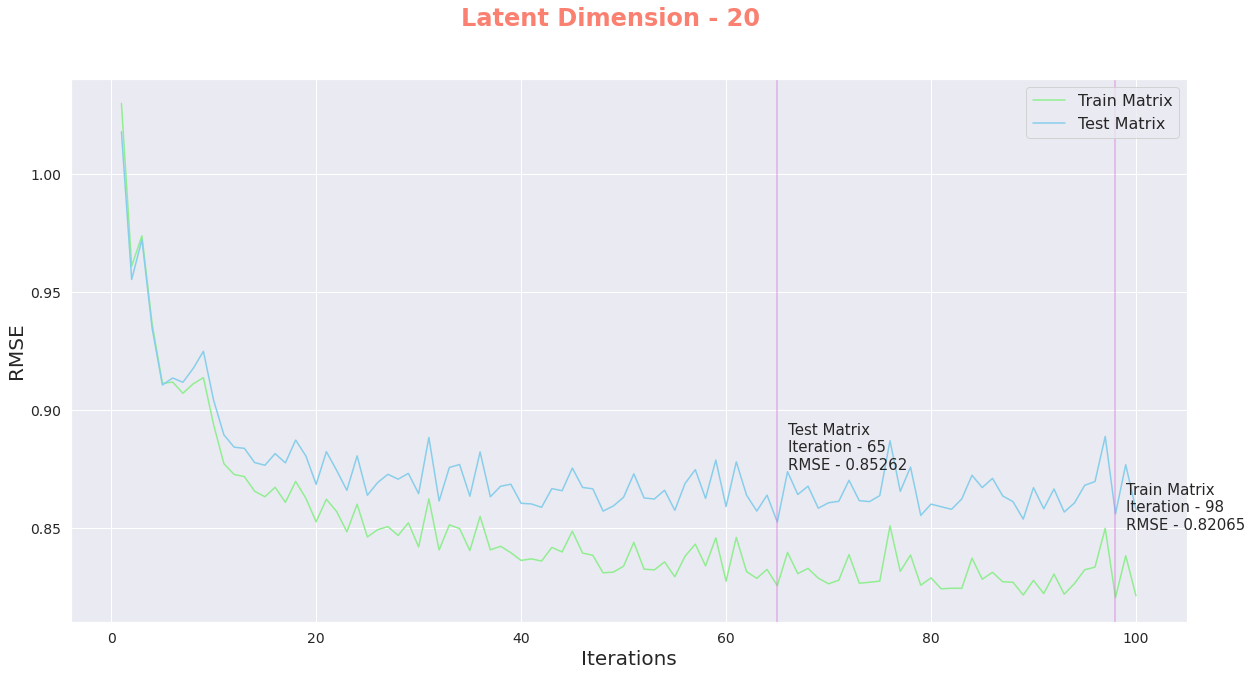

In [ ]:
plot_results(k_factor=20, what='RMSE', m1=train_rmse_k_20, m1_desc='Train Matrix', m2=test_rmse_k_20, m2_desc='Test Matrix')

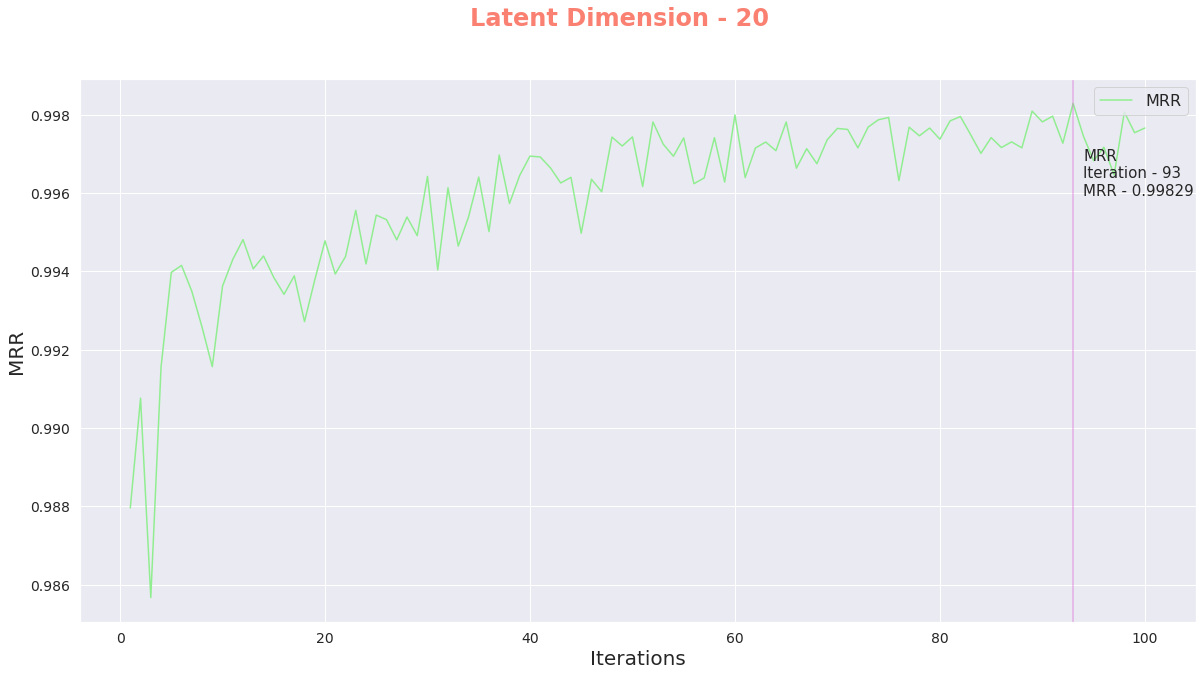

In [ ]:
plot_results(k_factor=20, what='MRR', m1=mrr_k_20, m1_desc='MRR', mark_max=True)

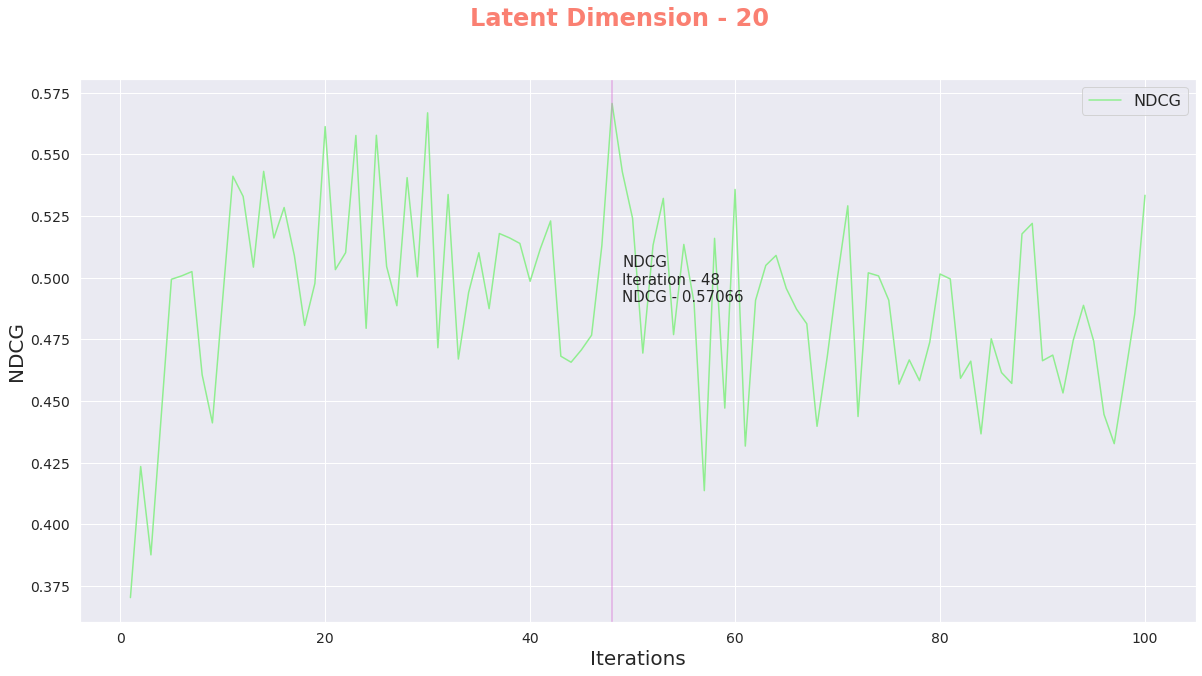

In [ ]:
plot_results(k_factor=20, what='NDCG', m1=ndcg_k_20, m1_desc='NDCG', mark_max=True)

#### Latent Dimension - 50

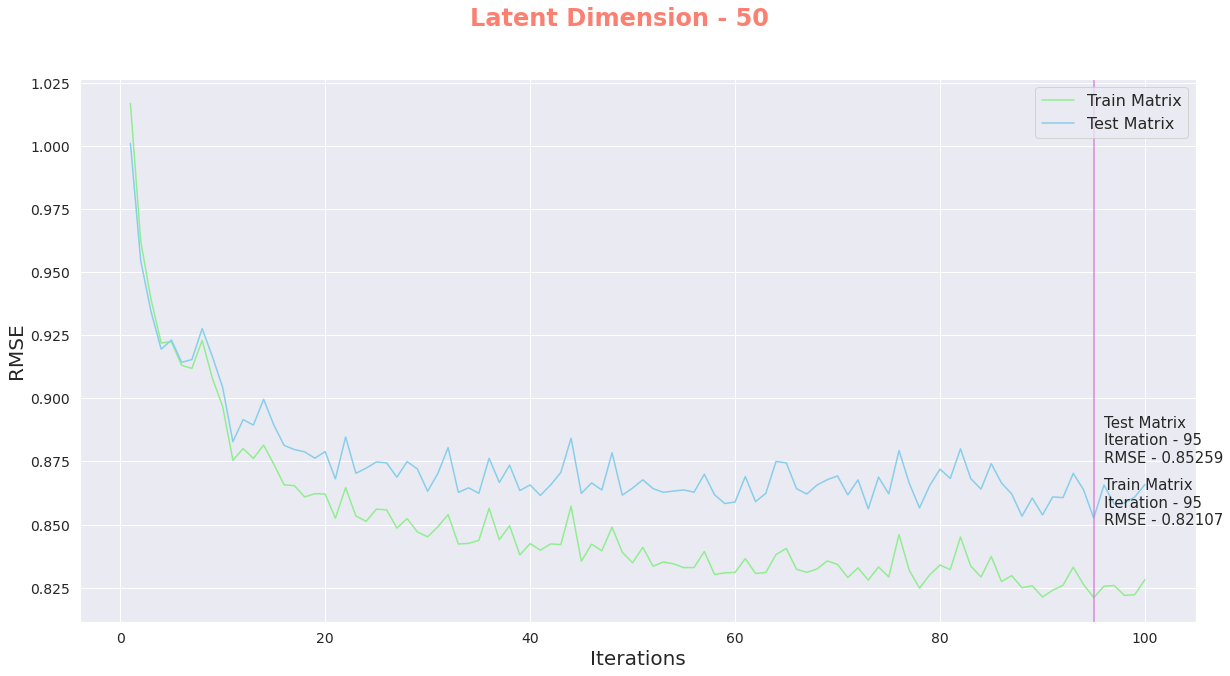

In [ ]:
plot_results(k_factor=50, what='RMSE', m1=train_rmse_k_50, m1_desc='Train Matrix', m2=test_rmse_k_50, m2_desc='Test Matrix')

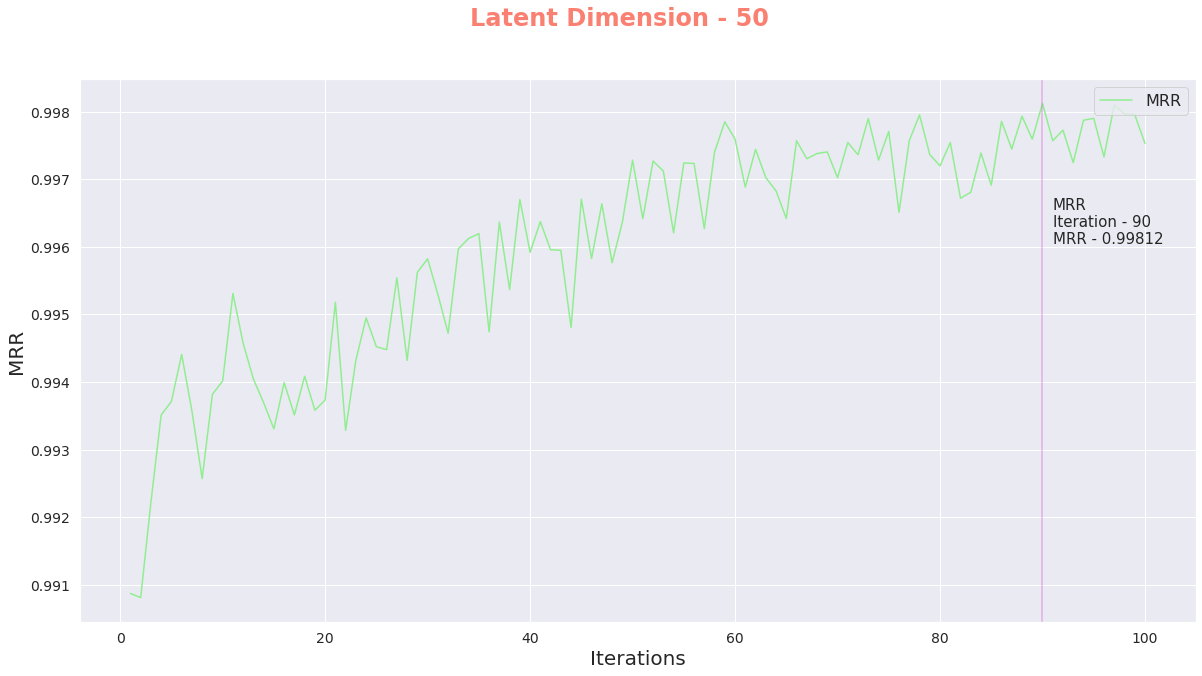

In [ ]:
plot_results(k_factor=50, what='MRR', m1=mrr_k_50, m1_desc='MRR', mark_max=True)

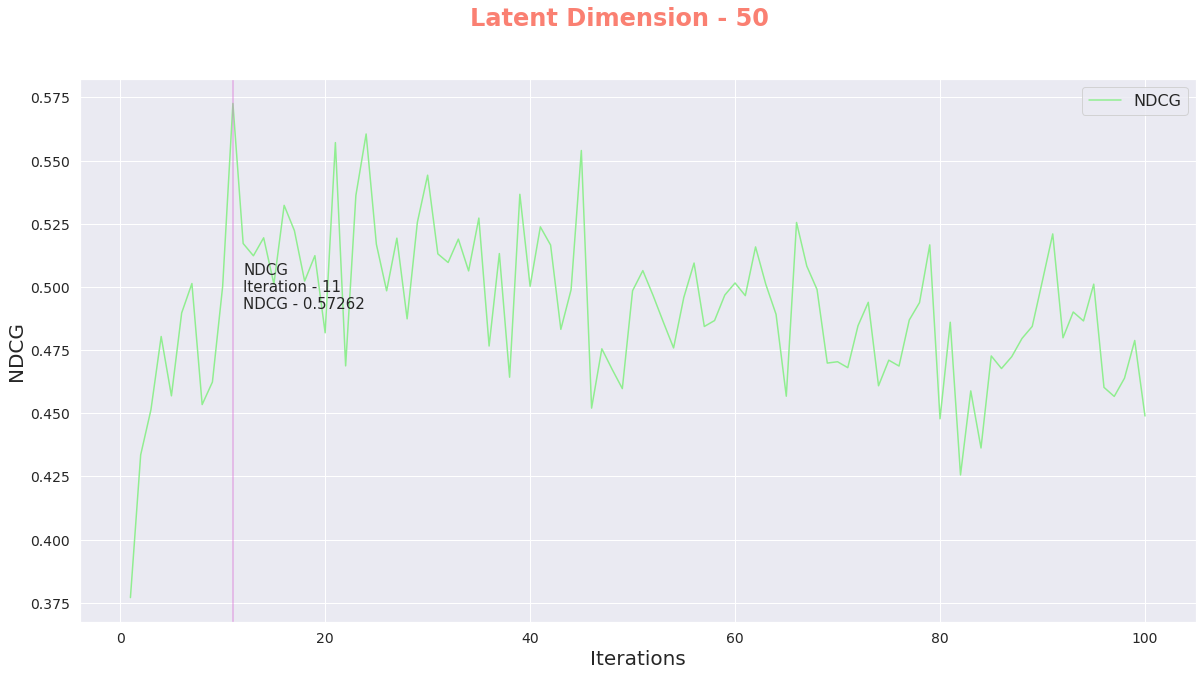

In [ ]:
plot_results(k_factor=50, what='NDCG', m1=ndcg_k_50, m1_desc='NDCG', mark_max=True)

#### Latent Dimension - 100

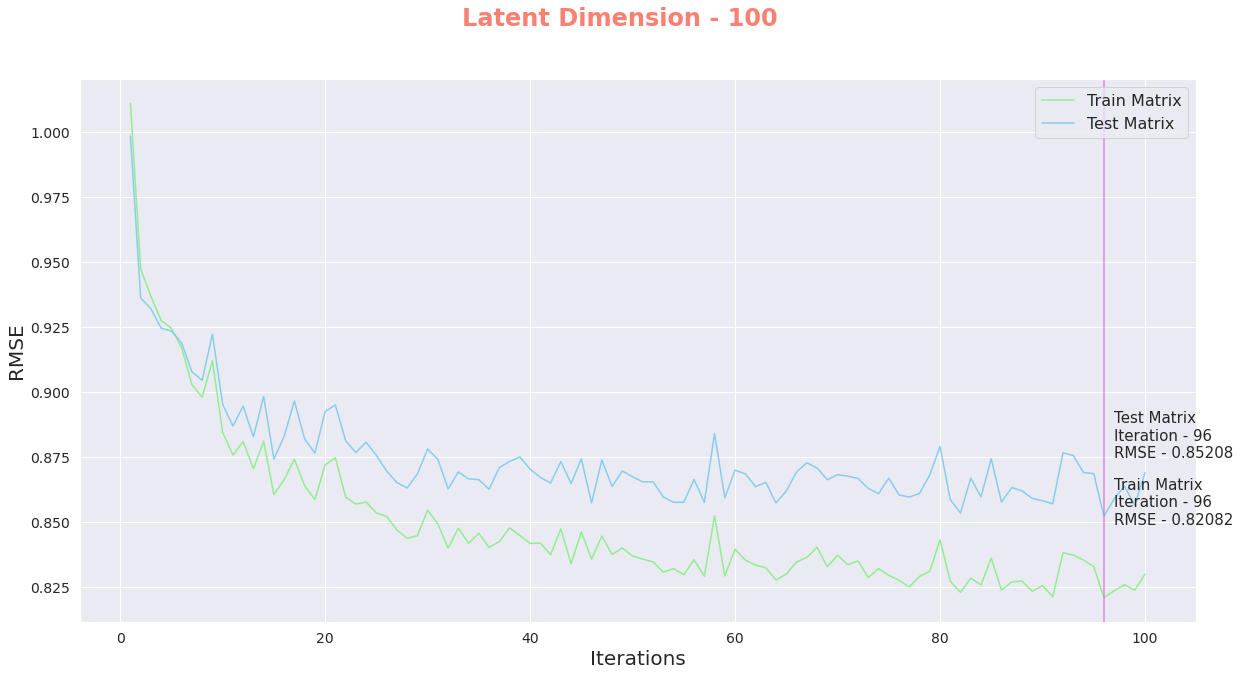

In [ ]:
plot_results(k_factor=100, what='RMSE', m1=train_rmse_k_100, m1_desc='Train Matrix', m2=test_rmse_k_100, m2_desc='Test Matrix')

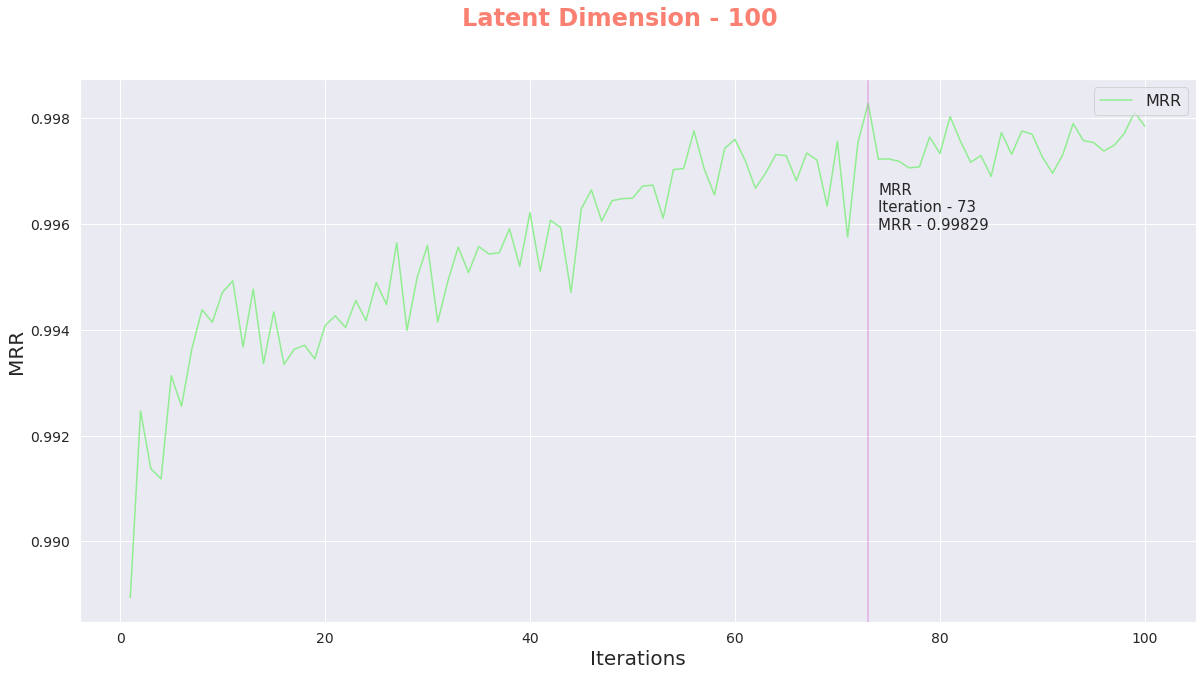

In [ ]:
plot_results(k_factor=100, what='MRR', m1=mrr_k_100, m1_desc='MRR', mark_max=True)

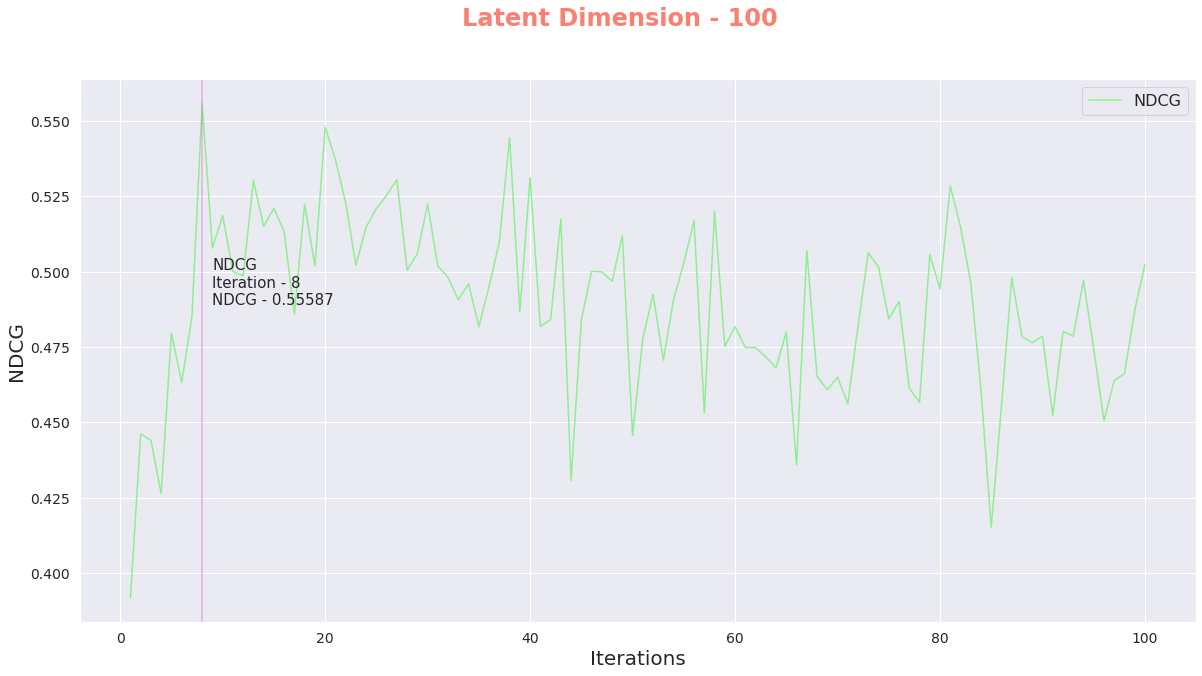

In [ ]:
plot_results(k_factor=100, what='NDCG', m1=ndcg_k_100, m1_desc='NDCG', mark_max=True)

## Test Matrix Size = 0.2 * Total Rating (200K ~)

### Main

In [ ]:
np.random.seed(123)
random.seed(123)

In [ ]:
cols = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df_ratings = pd.read_csv('ratings.dat', sep='::', header=None, names=cols, engine='python')
df_ratings['Rating'] = df_ratings['Rating'].astype(int)

df_pivot = df_ratings.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)

train_matrix = df_pivot.to_numpy()

In [ ]:
train_matrix.shape

(6040, 3706)

In [ ]:
test_matrix_y_indices, test_matrix_indices = np.where(train_matrix > 0)

n = int(df_ratings.shape[0] * 0.2)
random_indices = np.random.choice(test_matrix_y_indices.shape[0], n, replace=False)

test_matrix_y_indices = test_matrix_y_indices[random_indices]
test_matrix_indices = test_matrix_indices[random_indices]

test_matrix = np.zeros(train_matrix.shape)
test_matrix[test_matrix_y_indices, test_matrix_indices] = train_matrix[test_matrix_y_indices, test_matrix_indices]

train_matrix[test_matrix_y_indices, test_matrix_indices] = 0

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=20, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.0597298577997367
Test rmse: 1.0682313466436308
MRR: 0.9800966440660147
NDCG: 0.33236004058669605
Iteration: 1 completed in 81.96 seconds.

Train rmse: 0.9800197366048247
Test rmse: 0.990554287127084
MRR: 0.9827451310646672
NDCG: 0.403790468045953
Iteration: 2 completed in 83.0 seconds.

Train rmse: 0.9448704029061189
Test rmse: 0.9560362260875289
MRR: 0.9889518350486893
NDCG: 0.4706925495426918
Iteration: 3 completed in 82.06 seconds.

Train rmse: 0.9456846102303721
Test rmse: 0.9574263686023988
MRR: 0.9877784078963714
NDCG: 0.43515631153395506
Iteration: 4 completed in 83.1 seconds.

Train rmse: 0.9542004106209694
Test rmse: 0.96595232601642
MRR: 0.9844601783426284
NDCG: 0.42134824714498215
Iteration: 5 completed in 82.82 seconds.

Train rmse: 0.9351578260963901
Test rmse: 0.9475885461188902
MRR: 0.9891276829314908
NDCG: 0.46724854070595295
Iteration: 6 completed in 82.07 seconds.

Train rmse: 0.911040572838667
Test rmse: 0.9233621863249207
MRR: 0.9921980447808262
NDCG: 

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=50, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.0491856797810175
Test rmse: 1.0570248846796082
MRR: 0.9841015046395838
NDCG: 0.35918450376370165
Iteration: 1 completed in 88.82 seconds.

Train rmse: 0.9831605815361389
Test rmse: 0.9934734551657427
MRR: 0.9820859530462178
NDCG: 0.3917888338739714
Iteration: 2 completed in 87.23 seconds.

Train rmse: 0.9405353998365467
Test rmse: 0.9511572959038707
MRR: 0.9901502608870159
NDCG: 0.4670975966663597
Iteration: 3 completed in 87.93 seconds.

Train rmse: 0.9319177673011603
Test rmse: 0.9431138439324588
MRR: 0.9898941579943235
NDCG: 0.4717387950176609
Iteration: 4 completed in 86.78 seconds.

Train rmse: 0.9413835846697014
Test rmse: 0.9527342030684954
MRR: 0.9881364078342555
NDCG: 0.4432636866873802
Iteration: 5 completed in 88.4 seconds.

Train rmse: 0.9221591085378024
Test rmse: 0.9335277979173282
MRR: 0.9906473796622802
NDCG: 0.5084690588947772
Iteration: 6 completed in 87.85 seconds.

Train rmse: 0.9228986954894882
Test rmse: 0.9345563596306693
MRR: 0.9915445867598186
NDC

In [ ]:
mf_sgd = MF(train_matrix=train_matrix, k_factors=100, reg=0.1)

iter_array = np.arange(1, 101)

mf_sgd.start_train(iter_array=iter_array, test_matrix=test_matrix, learning_rate=0.01)

Train rmse: 1.076855062429455
Test rmse: 1.084864353709938
MRR: 0.9772451819244033
NDCG: 0.3475450480305073
Iteration: 1 completed in 89.42 seconds.

Train rmse: 1.0017048318648498
Test rmse: 1.0118349410886258
MRR: 0.9774628655009444
NDCG: 0.34740873398962624
Iteration: 2 completed in 88.78 seconds.

Train rmse: 0.9422847160654304
Test rmse: 0.9530962137004587
MRR: 0.9894435609460445
NDCG: 0.4405901051713793
Iteration: 3 completed in 87.81 seconds.

Train rmse: 0.9315223043971398
Test rmse: 0.942624107119213
MRR: 0.9905734318110146
NDCG: 0.45033881003553766
Iteration: 4 completed in 90.01 seconds.

Train rmse: 0.9193521624377667
Test rmse: 0.9303567864451697
MRR: 0.9929197043055633
NDCG: 0.48524272281383607
Iteration: 5 completed in 88.25 seconds.

Train rmse: 0.9286866865503071
Test rmse: 0.9399159539624359
MRR: 0.9897882532754222
NDCG: 0.4771711670358669
Iteration: 6 completed in 89.15 seconds.

Train rmse: 0.9210212705790052
Test rmse: 0.9324739912285825
MRR: 0.991432755985736
NDCG

### Results

#### Results Arrays

In [ ]:
iteration_time_k_20 = np.array(
    [81.96, 83.0, 82.06, 83.1, 82.82, 82.07, 82.39, 82.83, 81.88, 82.19, 82.68, 82.72, 83.36, 82.95, 82.34, 82.61,
     83.18, 82.45, 83.55, 82.91, 82.13, 83.46, 81.74, 82.98, 82.86, 82.54, 82.9, 84.24, 83.29, 83.56, 83.43, 83.64,
     82.82, 83.31, 81.58, 83.0, 83.68, 82.75, 82.48, 82.56, 82.0, 83.13, 82.26, 82.6, 83.34, 83.06, 82.01, 83.16, 83.82,
     82.53, 83.39, 83.56, 82.8, 83.97, 82.97, 82.18, 82.59, 82.42, 82.27, 82.41, 82.64, 82.27, 82.35, 83.86, 82.42,
     83.33, 84.0, 83.02, 83.0, 82.24, 82.33, 84.26, 83.24, 83.09, 81.79, 82.86, 83.34, 82.71, 82.81, 82.54, 83.02,
     82.19, 82.46, 83.77, 83.5, 82.5, 81.61, 82.04, 81.88, 83.92, 82.11, 82.92, 81.84, 83.32, 82.34, 83.23, 82.46,
     82.44, 82.35, 81.95])

train_rmse_k_20 = np.array(
    [1.0597298577997367, 0.9800197366048247, 0.9448704029061189, 0.9456846102303721, 0.9542004106209694,
     0.9351578260963901, 0.911040572838667, 0.929549793217273, 0.8989866469185601, 0.8994729944154078,
     0.8878591346724156, 0.8912688976116838, 0.8896023862722947, 0.8751347747065064, 0.8817790753243039,
     0.8722221949578458, 0.8746428661060686, 0.8576451018872137, 0.8623852439052743, 0.8638595930059402,
     0.8597740543338579, 0.8685006620776858, 0.8526299096134661, 0.8534564349210831, 0.8561170910794687,
     0.8515944377010856, 0.8521978221204863, 0.8504104868771158, 0.8526525238691354, 0.8407334822197019,
     0.8524573659050684, 0.8400802288683945, 0.8536813841393311, 0.845799542668453, 0.8449712985525818,
     0.8432624069514798, 0.8407914518769641, 0.8356192711862925, 0.8558581350385899, 0.8332162686402469,
     0.8335200347027438, 0.8498877399415121, 0.8508132369030028, 0.8372148343225319, 0.8352495851675452,
     0.8305988011837095, 0.8428097495891548, 0.8251897923231428, 0.833196569594778, 0.8338953954623308,
     0.8311610939419972, 0.828450658387431, 0.823713688876116, 0.8256387574159298, 0.8347712493243294,
     0.8270739518173994, 0.8354093473004911, 0.8360897809957533, 0.8292221622846614, 0.8363871204807637,
     0.8197372478409467, 0.8273026231644931, 0.8216427559667399, 0.8183525723023352, 0.8292164835044707,
     0.8248016807107886, 0.8284527600607171, 0.8251846200070754, 0.8167874578300818, 0.8220299338599232,
     0.8205736087563654, 0.8254854483760998, 0.8152738879379094, 0.8276474118098797, 0.818439826801095,
     0.8219595728888002, 0.8291604062878288, 0.8155732841789403, 0.8171518379463876, 0.8193927032274185,
     0.8247225816270326, 0.8126358599786094, 0.811720951175333, 0.83139844624465, 0.8165131231633037,
     0.8250920580902319, 0.8150170694583981, 0.811047960432284, 0.8238797796985153, 0.8176148250053819,
     0.8167325586477041, 0.8261971769011435, 0.8095064008042343, 0.8091655186554405, 0.8145654160890208,
     0.8192930380863999, 0.8220087695138469, 0.812887205441974, 0.8192831533575637, 0.8123596704744164])

test_rmse_k_20 = np.array(
    [1.0682313466436308, 0.990554287127084, 0.9560362260875289, 0.9574263686023988, 0.96595232601642,
     0.9475885461188902, 0.9233621863249207, 0.9428424349320189, 0.9126899038953941, 0.9145144809061048,
     0.9038032356308439, 0.9080110754052917, 0.9071440353804633, 0.893517220744946, 0.9007755599781664,
     0.8919761844873838, 0.8953118518336433, 0.8790545369376477, 0.8844419739785371, 0.8868096991277709,
     0.8836200925689732, 0.8927669178271136, 0.8772870293619549, 0.8789306075824986, 0.8817313020299689,
     0.8779695353671736, 0.8795156090336071, 0.877998716550723, 0.8808424602659412, 0.8695697239311253,
     0.8820786902485982, 0.8701933312480069, 0.884384629664187, 0.876943549513439, 0.8756901267364907,
     0.8757910084890222, 0.8732877947954466, 0.8685482993145782, 0.8891594550714733, 0.8674919864553635,
     0.8679360691887852, 0.8844612222518333, 0.8859796663274621, 0.8729048158199035, 0.8712662460131835,
     0.8671627614499694, 0.8799986357000597, 0.862364003584201, 0.8711984788006002, 0.8715847010624572,
     0.8695834311263005, 0.8673870894971049, 0.8632448106787373, 0.8655236610483009, 0.87437990640712,
     0.8675869701679888, 0.8760328144147623, 0.8769572027951604, 0.8706591516382035, 0.8783569357561252,
     0.8617854092738816, 0.8696091241145071, 0.8645275040313641, 0.8617327010938236, 0.8722151587351927,
     0.8680384552576608, 0.8723563838422957, 0.8693383950089293, 0.8611521405658888, 0.8668349561063872,
     0.8655616354249903, 0.8708957145522501, 0.8611627403311858, 0.8731243652852356, 0.8646568334280291,
     0.8683490070299748, 0.8754996064478402, 0.8628371653970848, 0.8644203727347075, 0.8670809823467156,
     0.8723304481866981, 0.8607539939805434, 0.8601820257230974, 0.8794490580349776, 0.8650208737849877,
     0.8734284744520707, 0.864157605455714, 0.8608531533939134, 0.8732399724192859, 0.8674655331998207,
     0.8668451793489524, 0.876049783610225, 0.8605451664923778, 0.8599174400644503, 0.8654968756139575,
     0.8705694473529835, 0.8736720430347114, 0.8647916841031712, 0.8713256012076785, 0.86440644488167])

mrr_k_20 = np.array([0.9800966440660147, 0.9827451310646672, 0.9889518350486893, 0.9877784078963714, 0.9844601783426284,
                     0.9891276829314908, 0.9921980447808262, 0.9896117513832746, 0.9932962787764114, 0.9922863808377053,
                     0.9937618259224219, 0.9927307267787401, 0.9931515485985685, 0.9941769516355609, 0.9927391464311995,
                     0.9932663556090708, 0.9928455498695564, 0.9948872898624553, 0.993203642384106, 0.9925294752157335,
                     0.9933209161147903, 0.9916942604856513, 0.9941280353200884, 0.9943487858719648, 0.9942935982339957,
                     0.9941611479028699, 0.994480483644391, 0.9949144591611478, 0.9943487858719648, 0.9954387417218543,
                     0.994253461770018, 0.995521523178808, 0.9942384105960265, 0.9949357816576359, 0.9952386865342162,
                     0.9954421909492275, 0.9953042218543046, 0.9960816777041943, 0.9946109271523178, 0.9957809050772627,
                     0.996316225165563, 0.9944300622115191, 0.9947779552247554, 0.9958181567328918, 0.9960154525386313,
                     0.9962932303164092, 0.9955339403973509, 0.9969370860927153, 0.9963079470198675, 0.9967163355408387,
                     0.9964679911699779, 0.9967494481236202, 0.9968494757174392, 0.9966121688741723, 0.996074779249448,
                     0.9968175128771156, 0.9956786825205699, 0.9965562913907284, 0.9968163631346578, 0.9962444812362031,
                     0.9974806843267109, 0.9968868259224221, 0.9969922737306844, 0.9979856512141282, 0.9970161883738043,
                     0.9976048565121414, 0.9965294859665721, 0.9966307947019869, 0.9978476821192055, 0.9973289183222959,
                     0.9972142785470601, 0.9971688741721854, 0.9978476821192053, 0.9962382022345362, 0.9977511037527594,
                     0.9973723158739716, 0.9965100944982854, 0.9982064017660045, 0.9978476821192053, 0.9974889624724063,
                     0.9969253587196468, 0.9981311458960467, 0.9984271523178808, 0.9966032008830022, 0.9980408388520972,
                     0.9973647902869758, 0.9977580022075057, 0.9983167770419427, 0.9969335741521171, 0.9976890176600443,
                     0.9978351394742124, 0.997201986754967, 0.9981788079470199, 0.9982891832229581, 0.9980759582580775,
                     0.9975826483513334, 0.9973384507324905, 0.9980684326710818, 0.9975027593818985,
                     0.9980423040106273])

ndcg_k_20 = np.array(
    [0.33236004058669605, 0.403790468045953, 0.4706925495426918, 0.43515631153395506, 0.42134824714498215,
     0.46724854070595295, 0.5109739098393018, 0.471169034724617, 0.5125304799449396, 0.48568949749412654,
     0.5028694327986769, 0.4683377431420482, 0.4725717706217064, 0.49170539421464154, 0.5050234654490172,
     0.5208903807885088, 0.4953797936966559, 0.5456309080187163, 0.5088675277477727, 0.4833498275792099,
     0.5175974657630898, 0.5062510214671184, 0.5400218041350914, 0.5073992962208913, 0.5237850514141433,
     0.5211154843127892, 0.506473623540981, 0.5433576190988961, 0.48400850669012907, 0.5411764582453935,
     0.47391980583055343, 0.5211387277984368, 0.4679577632932773, 0.49696653346283237, 0.46778967822258505,
     0.4850784263995101, 0.5235177579134769, 0.5449064221939321, 0.45706338692965576, 0.5173788810877091,
     0.5336439793193637, 0.45194733287208677, 0.4710159870175356, 0.4902117600235168, 0.47584636980284717,
     0.5007921856971962, 0.481316481344024, 0.5535770832259248, 0.49142003944652407, 0.4797135045293831,
     0.5022012554166043, 0.5011566404680844, 0.5480095800659499, 0.49169404539323486, 0.4772935501975677,
     0.49442524387485026, 0.4728813003437169, 0.4443859950387088, 0.43985418705589535, 0.47920360679142093,
     0.5131565252972505, 0.5037706059055963, 0.47793968167479306, 0.5168678610294967, 0.44942904203268347,
     0.48071814331568324, 0.49244794801300174, 0.49343969078887495, 0.5231417574433337, 0.462003764618749,
     0.4727697611127598, 0.4767472531512464, 0.5009985981125648, 0.4937000819799284, 0.5196859274388738,
     0.4566970183744141, 0.4502114601674251, 0.5081913083988667, 0.47659260471224635, 0.4846283290630879,
     0.5085664248983416, 0.5317581496490846, 0.5124060634812898, 0.4307676726331011, 0.4913105335920306,
     0.45387918021086887, 0.51865439821074, 0.5123515864009328, 0.47085741627036437, 0.45467446747709,
     0.4715614345435584, 0.42198992936005636, 0.46024354530125033, 0.5071843947725511, 0.4871960660386453,
     0.4676313723041557, 0.45555696255486894, 0.45305444045472876, 0.4934479773299162, 0.46974303736017686])

In [ ]:
iteration_time_k_50 = np.array(
    [88.82, 87.23, 87.93, 86.78, 88.4, 87.85, 88.69, 86.76, 89.25, 87.96, 87.86, 88.71, 87.82, 89.02, 87.22, 89.09,
     87.34, 87.64, 88.12, 88.94, 86.61, 87.46, 87.77, 88.8, 87.47, 87.05, 87.55, 88.3, 87.63, 88.11, 88.33, 88.52, 89.1,
     89.28, 88.31, 86.88, 88.09, 88.89, 88.84, 88.63, 86.94, 88.0, 88.39, 87.99, 88.68, 88.62, 88.14, 88.33, 88.18,
     88.32, 87.76, 88.14, 88.74, 88.25, 88.34, 87.23, 88.61, 88.62, 87.53, 89.57, 88.61, 89.11, 88.71, 87.05, 89.12,
     89.09, 86.76, 89.2, 88.88, 87.82, 88.64, 86.72, 87.58, 87.94, 88.2, 88.14, 87.72, 88.8, 88.96, 87.49, 87.09, 88.31,
     87.94, 88.59, 87.26, 88.23, 88.54, 88.5, 87.89, 88.08, 87.86, 87.89, 88.09, 88.76, 87.85, 89.05, 87.4, 88.55,
     87.82, 86.69])

train_rmse_k_50 = np.array(
    [1.0491856797810175, 0.9831605815361389, 0.9405353998365467, 0.9319177673011603, 0.9413835846697014,
     0.9221591085378024, 0.9228986954894882, 0.9183078046832547, 0.9001881120474543, 0.9450400593291611,
     0.909530319391699, 0.9087874972845379, 0.8755986426782777, 0.8849616949196181, 0.8723825994379825,
     0.8773290362003386, 0.889446848602137, 0.8738498480870456, 0.8660374934668784, 0.8639647735364261,
     0.8737927768071766, 0.8587596800374839, 0.8634925746590668, 0.8822995365198308, 0.86318116787531,
     0.8586396908934649, 0.8530785888890993, 0.8611041222603605, 0.8567915698986366, 0.8552097118698048,
     0.8437986484121267, 0.8476015484777808, 0.8438066752007715, 0.8495671488443394, 0.8431749545369133,
     0.8416898292772097, 0.85104321269325, 0.8455721910671241, 0.8404998546603284, 0.8374168028536504,
     0.8415805197491643, 0.8349675459814543, 0.8557007964240172, 0.8350189102871658, 0.8313927765071242,
     0.8303084629948958, 0.8288196580809237, 0.8362641867396864, 0.8284964055908335, 0.8304752241873363,
     0.8282632431992613, 0.8352535988481775, 0.8343961967769263, 0.8308989226498651, 0.8231070059629918,
     0.8215309336540572, 0.8223180053347808, 0.826994976505586, 0.8253329387839681, 0.8309213194405064,
     0.8277742680683281, 0.8313462798777623, 0.8241706547670304, 0.8246897486963002, 0.8212647367732357,
     0.8230538117780618, 0.8200892435825266, 0.8305994156026034, 0.8180874560950874, 0.8186293342089552,
     0.8269976395589419, 0.8143810760325152, 0.8237297396649074, 0.8142301736671438, 0.8184678295038347,
     0.8237750856127528, 0.82968538266028, 0.823786025321138, 0.8238620897309925, 0.8246474768558537,
     0.8187712440911871, 0.811519524427166, 0.8168698791653052, 0.8106427197137798, 0.8153157491668821,
     0.8122163191287606, 0.8256252635080064, 0.8130326372434027, 0.8179967353837672, 0.8211542206544125,
     0.8164576202636084, 0.8112608321811838, 0.8090059459480614, 0.8085517305731902, 0.8097314031436427,
     0.8069736570059882, 0.8286430492521525, 0.8179742281543295, 0.8207718945774646, 0.8195674801436093])

test_rmse_k_50 = np.array(
    [1.0570248846796082, 0.9934734551657427, 0.9511572959038707, 0.9431138439324588, 0.9527342030684954,
     0.9335277979173282, 0.9345563596306693, 0.9301912936761221, 0.9125206904636909, 0.958144309314618,
     0.923672976854991, 0.9236544720193509, 0.8916397506280639, 0.9015351046011338, 0.8900950677595505,
     0.8955515286329914, 0.9088207458275575, 0.8940106102304934, 0.8869766139755519, 0.8855473073871447,
     0.8962992771986747, 0.8820605761011631, 0.8871316125136299, 0.9062893315673515, 0.8878559552011103,
     0.8841795691659147, 0.8789232000502648, 0.8878804116118859, 0.8839791053464879, 0.8832246936499322,
     0.8722715310110473, 0.8765335377948537, 0.872987306234255, 0.8793455730211308, 0.8735317101258467,
     0.8724757792785883, 0.8823942368393655, 0.8778179177039616, 0.8725064427809989, 0.870561268944334,
     0.8750573531625435, 0.8683217232458449, 0.8895243617486412, 0.8698420538568971, 0.8661643651493789,
     0.8659504104314687, 0.8650205233269898, 0.8729334453343128, 0.86512554172531, 0.8678760958059233,
     0.8659771100228735, 0.873639656239464, 0.8729169482933551, 0.8701164924011762, 0.8626262170331273,
     0.8611425556953028, 0.8619134920300748, 0.8669843768369205, 0.8662380081737819, 0.8721892599780903,
     0.8694863399850455, 0.8733461593172642, 0.8663876551030247, 0.8672718637930863, 0.8646120303338198,
     0.866013002873339, 0.8640010723827941, 0.8744887273012074, 0.8626749198235723, 0.8635828483605569,
     0.8715719348064509, 0.8594771891332519, 0.8687821943052578, 0.8603821617383486, 0.8647617022892019,
     0.8701373276352004, 0.8760153701596524, 0.8709273259060771, 0.8713643286073798, 0.8724015275286846,
     0.8663603290303262, 0.8593281325204019, 0.8655214897708069, 0.859437701293698, 0.8643449831043711,
     0.8617042411300351, 0.8749137856231611, 0.8629084537949769, 0.8680224883533767, 0.8710696330237949,
     0.8668546072338722, 0.8622919093696244, 0.8602990469187034, 0.8604091729845512, 0.8618381462615813,
     0.8594716676098385, 0.8803490867014417, 0.8700568058075384, 0.8736762277100171, 0.8723601517352528])

mrr_k_50 = np.array([0.9841015046395838, 0.9820859530462178, 0.9901502608870159, 0.9898941579943235, 0.9881364078342555,
                     0.9906473796622802, 0.9915445867598186, 0.9915895252650218, 0.9942968731048202, 0.988549562560324,
                     0.9914309265054296, 0.9911936554982913, 0.9954884105960267, 0.9938473667612739, 0.994575055187638,
                     0.993569887617901, 0.991966059602649, 0.9932353752759383, 0.9934871061609472, 0.9935513245033113,
                     0.9918058900260888, 0.9934940046156935, 0.992237733293197, 0.9914526891430864, 0.9934187487457355,
                     0.9936175496688743, 0.9939762693156735, 0.9929749320767532, 0.9932277869757176, 0.9935568432671082,
                     0.9949297212291701, 0.9945960689420953, 0.9954663355408387, 0.994569536423841, 0.995217991169978,
                     0.9954111479028698, 0.9941349337748344, 0.9944645055551512, 0.9957698675496689, 0.9953751505117399,
                     0.9952952538631348, 0.9956291390728476, 0.9940379212399079, 0.9957994681918523, 0.99617825607064,
                     0.9959368956221063, 0.9961320364238411, 0.9960596026490066, 0.9966348083483846, 0.996523178807947,
                     0.996523178807947, 0.9956939141550659, 0.9961699779249447, 0.9962946954749393, 0.9973033313265103,
                     0.9980408388520972, 0.9975634657836645, 0.9969094922737308, 0.9967514549468192, 0.9959843467790487,
                     0.9963079470198675, 0.9961935181386625, 0.9970713760117733, 0.9970171081677704, 0.9976379690949227,
                     0.9967540470934511, 0.9974438925680649, 0.9967633415149971, 0.9977083333333334, 0.9973772075055188,
                     0.9969430929104534, 0.99848233995585, 0.9972295805739514, 0.997935982339956, 0.9977503511940599,
                     0.9970785044150109, 0.9964272275737507, 0.9972812562713225, 0.9971909492273732, 0.9971127667402503,
                     0.9978938390527794, 0.9983443708609272, 0.9979028697571745, 0.99848233995585, 0.99799747713655,
                     0.9980270419426049, 0.996435591187027, 0.9979269516355609, 0.9977206878386515, 0.9973067805538832,
                     0.9978407836644593, 0.9982139273530003, 0.998233995584989, 0.9982615894039735, 0.9983443708609272,
                     0.9983719646799117, 0.9967701434878588, 0.9974131649377795, 0.9975772626931567,
                     0.9970991370660244])

ndcg_k_50 = np.array(
    [0.35918450376370165, 0.3917888338739714, 0.4670975966663597, 0.4717387950176609, 0.4432636866873802,
     0.5084690588947772, 0.47724974668890185, 0.5033638384148307, 0.5310049192205543, 0.43488344925767985,
     0.4570015680295804, 0.47325159884662094, 0.5734750755325232, 0.5214200440080654, 0.5163393181304482,
     0.5003543416914522, 0.4736236932673271, 0.517651742444889, 0.5192461603709544, 0.49716851192237427,
     0.4814631602476406, 0.537889840035071, 0.5040884223770357, 0.46805997462291565, 0.5020702721551532,
     0.5032593708224522, 0.5005322213857673, 0.46829489309646943, 0.49948035757830994, 0.47913147442251475,
     0.5228362012699976, 0.4829678664390867, 0.5370933431708909, 0.48509958453740554, 0.5068978120313188,
     0.5146814668259824, 0.4911828181477638, 0.4843256907457252, 0.5405377536202519, 0.5357731969161273,
     0.5215146086034651, 0.5036516615446589, 0.45312020848307677, 0.4949710828060519, 0.5067756522719085,
     0.5073215013028324, 0.49595397632064164, 0.46484629602842326, 0.4974488306048743, 0.4911644931500259,
     0.5040709132566646, 0.44666317539934014, 0.48477342482030467, 0.4852618766234508, 0.5225698582195616,
     0.5285530266858613, 0.5009612585194853, 0.4882728287246858, 0.49396524356730664, 0.47018364685228886,
     0.48216124212769246, 0.4714648751972401, 0.4965229408056972, 0.48186529715889476, 0.4978319373921294,
     0.4999918791463111, 0.49933278515277196, 0.48656363745329934, 0.4729207074264912, 0.5170192505987502,
     0.512071682092741, 0.5162488312074898, 0.4866991007840709, 0.4940097304174923, 0.4999644282944766,
     0.46237183684684763, 0.45248842316288884, 0.43186892269541355, 0.47243100939378196, 0.4221052799389524,
     0.4548282061811795, 0.51893925830593, 0.5006868797936944, 0.5177470915320995, 0.4796302692414548,
     0.46806646231955906, 0.4625296548625876, 0.4626154580496265, 0.4689691817573779, 0.4494515723731808,
     0.48663601211491336, 0.47117751052024526, 0.5207530749118268, 0.48276905211410004, 0.4854471094585408,
     0.5063603520000914, 0.4611447499550569, 0.48214288546765427, 0.46548206667413317, 0.4703521864426793])

In [ ]:
iteration_time_k_100 = np.array(
    [89.42, 88.78, 87.81, 90.01, 88.25, 89.15, 90.11, 89.03, 88.95, 88.88, 88.61, 89.55, 89.07, 88.94, 88.43, 89.29,
     88.97, 89.6, 89.43, 88.43, 88.49, 88.34, 89.62, 89.45, 89.18, 89.86, 90.22, 88.64, 88.71, 90.31, 88.82, 88.21,
     90.1, 90.12, 89.23, 89.2, 88.85, 88.81, 89.27, 88.82, 89.48, 89.68, 88.04, 88.5, 88.6, 88.45, 88.89, 89.4, 88.2,
     89.27, 89.02, 89.18, 88.23, 89.81, 89.02, 89.42, 90.02, 89.25, 89.35, 90.29, 88.82, 89.9, 88.74, 89.49, 88.6,
     89.27, 89.44, 88.76, 89.72, 90.11, 90.02, 90.75, 89.82, 89.84, 89.37, 88.88, 89.22, 89.1, 90.06, 89.37, 89.06,
     88.5, 89.48, 88.26, 90.34, 89.11, 89.33, 90.06, 89.83, 89.62, 89.61, 88.66, 89.42, 89.25, 88.83, 89.31, 88.69,
     88.39, 89.13, 88.57])

train_rmse_k_100 = np.array(
    [1.076855062429455, 1.0017048318648498, 0.9422847160654304, 0.9315223043971398, 0.9193521624377667,
     0.9286866865503071, 0.9210212705790052, 0.9134596548168854, 0.9102003542264223, 0.9111959511134483,
     0.9086247946894626, 0.8971433410497853, 0.8884513356202501, 0.8923618240072632, 0.8832548064495584,
     0.8770793773038504, 0.8741269409797332, 0.8819512377352019, 0.8763726740606658, 0.8710488216923125,
     0.8649594352448328, 0.868275709103307, 0.8530510717372389, 0.8649827518951244, 0.859322179696817,
     0.8564057421518353, 0.8620912616338714, 0.8641079231018554, 0.8545194968313421, 0.86646169881527,
     0.8561986204713029, 0.8501126359141743, 0.8446298072017869, 0.845578471857843, 0.8464346442967744,
     0.8561828260629989, 0.8475137987492655, 0.8505697401794987, 0.8437430197525344, 0.8371384892127115,
     0.8337297127749631, 0.8400152449482026, 0.8466243884806659, 0.8360037143432207, 0.834637714914988,
     0.8379469615575645, 0.8321425564026262, 0.842412607932999, 0.829139406288555, 0.8308013952156628,
     0.8301191845681591, 0.8341815809622537, 0.8273259823805009, 0.8304747839677502, 0.8372748579515517,
     0.8265639342072172, 0.8259364775992077, 0.82854522176323, 0.8267310975205998, 0.8279958176007384,
     0.8248282389745877, 0.8251911302085776, 0.8214421183061807, 0.8254666137055896, 0.8383185188727291,
     0.8237447538928325, 0.8302402981962156, 0.8243445828365371, 0.8237793706623279, 0.8225167215144379,
     0.8223738321868995, 0.8182955995104735, 0.8165022784623367, 0.8300967654856385, 0.817372947506849,
     0.8234109883842344, 0.8197851590629586, 0.8183620076742731, 0.8215291706446225, 0.8210113746112516,
     0.8273927148237596, 0.8398549788495595, 0.8290608862273036, 0.8156754919375842, 0.8230653330584146,
     0.8149930858880379, 0.8250645107561825, 0.8255948895261437, 0.8171952775893911, 0.8167784554412676,
     0.8183301906968361, 0.8193995084325184, 0.8212732307230594, 0.8159909974298492, 0.8180297423998845,
     0.8205619818216469, 0.8094888600230418, 0.8101999793712199, 0.8126277758050816, 0.815146137991911])

test_rmse_k_100 = np.array(
    [1.084864353709938, 1.0118349410886258, 0.9530962137004587, 0.942624107119213, 0.9303567864451697,
     0.9399159539624359, 0.9324739912285825, 0.9247087091445079, 0.9221953018599544, 0.9234477372200435,
     0.9218468960803435, 0.9113637266304221, 0.9032407433361878, 0.9082072838188597, 0.9000481955842261,
     0.8946516794508024, 0.892356425641449, 0.9009914553003004, 0.896293653915069, 0.8916258857462654,
     0.8863423047411695, 0.8903346749074942, 0.8757838879822702, 0.8881929136816413, 0.882795892648138,
     0.880685384541635, 0.8870429225009399, 0.8894899997834734, 0.8800368599321351, 0.8924474691651043,
     0.8830487787023188, 0.8768033205781892, 0.872382506792355, 0.8737190411452671, 0.8754089414067472,
     0.8853306207918822, 0.8774735149241275, 0.8807237852791066, 0.8743279914542978, 0.8682509682907523,
     0.865277601663909, 0.8717699580911472, 0.8789910379225503, 0.8690221367195173, 0.867806067678512,
     0.872108322374539, 0.8665034161414854, 0.8770828450353972, 0.8640462457827428, 0.8660504129041726,
     0.8662939700028964, 0.8703739043286538, 0.8640406341164377, 0.8676434397518403, 0.8750061930254338,
     0.8645815585106799, 0.8643318180312828, 0.8672200292624961, 0.8659577341405057, 0.8673727017745487,
     0.8647598369850633, 0.865343844787579, 0.8622910710445997, 0.8658834376562354, 0.8793317625602364,
     0.865422300708579, 0.8716750469054245, 0.866112984561178, 0.8661452401342465, 0.8655379009447024,
     0.8651986790048175, 0.8615013069006664, 0.8597393954406755, 0.8738505857830584, 0.8614395439465186,
     0.8677999831209054, 0.8642813682320108, 0.862993286731104, 0.866782756484372, 0.8665805030625385,
     0.8726580739602808, 0.8860195270153419, 0.875425032451352, 0.8625005597117663, 0.870497975582719,
     0.8621846385550582, 0.8724456205832969, 0.8738158076196825, 0.865590416425819, 0.8656275060179941,
     0.8668704580164852, 0.8685147479758188, 0.8702764019923253, 0.8654172076443117, 0.8680620544004792,
     0.8712578252315335, 0.8602930499182564, 0.8606536058208626, 0.8634379665623417, 0.8660229297612788])

mrr_k_100 = np.array(
    [0.9772451819244033, 0.9774628655009444, 0.9894435609460445, 0.9905734318110146, 0.9929197043055633,
     0.9897882532754222, 0.991432755985736, 0.9929070745295911, 0.9931730521134494, 0.9919281838011141,
     0.9925695358725158, 0.9941166035950805, 0.9943724377168087, 0.9933479186376538, 0.9941045805739513,
     0.9945605057194462, 0.9942707706201084, 0.9926519631031221, 0.9924172185430463, 0.9931043046357615,
     0.9931158438691551, 0.9930518763796911, 0.9941804635761592, 0.9928118101545255, 0.9939900662251655,
     0.9937141280353201, 0.9932588300220752, 0.9935430463576159, 0.9942798013245033, 0.9929346881165875,
     0.9937451006892823, 0.9945645193658439, 0.9955491169977924, 0.9953076710816777, 0.9944512013924266,
     0.9941631547260686, 0.9946143763796909, 0.9941948249046759, 0.9949081878386513, 0.9956870860927152,
     0.9969067328918322, 0.995698123620309, 0.9955160044150111, 0.9956456953642384, 0.9955413842166613,
     0.9958333333333332, 0.9962141638714485, 0.9950137569506231, 0.9969646799116997, 0.996450055187638,
     0.9968405077262692, 0.9960961017459361, 0.9969665194996321, 0.9964238410596026, 0.9956567328918322,
     0.9968267108167771, 0.9967163355408387, 0.9960809251454946, 0.9967163355408387, 0.9967071376011774,
     0.9971164459161149, 0.996978476821192, 0.9975220750551878, 0.9968653421633554, 0.9957753863134658,
     0.9969140912435615, 0.9961009933774834, 0.996512101321484, 0.9972958057395144, 0.9974438925680649,
     0.9973565121412803, 0.9977724262492476, 0.9978787251655629, 0.9968892568064753, 0.9979856512141282,
     0.9974613686534217, 0.9978476821192053, 0.9973565121412804, 0.99748206401766, 0.9975496688741723,
     0.9973841059602648, 0.996425220750552, 0.9969832430262895, 0.9978807947019868, 0.9971265636497426,
     0.9980739514348786, 0.996752995900347, 0.9974206905247754, 0.9978460097665396, 0.9980069737106162,
     0.9975456152689054, 0.9975441501103753, 0.9973695564920732, 0.9977207505518764, 0.9973716887417219,
     0.9976758478828016, 0.9981587397150311, 0.9980684326710818, 0.9978200883002208, 0.9977089604655831])

ndcg_k_100 = np.array(
    [0.3475450480305073, 0.34740873398962624, 0.4405901051713793, 0.45033881003553766, 0.48524272281383607,
     0.4771711670358669, 0.4567009472965045, 0.514356365027081, 0.5075843029968155, 0.4917531349811332,
     0.4809747204689666, 0.5177977319938843, 0.4869411965967134, 0.48501674721177607, 0.5265912932733785,
     0.5139361761332486, 0.5218667239606418, 0.4767004707238088, 0.5182330531579307, 0.5080009757798395,
     0.494055075342256, 0.49505343644429595, 0.5503369325045183, 0.5182661632458474, 0.5123387253173155,
     0.5224475233845768, 0.4830474265834097, 0.4997051290262364, 0.5000757292189524, 0.4676904631508844,
     0.5040896492027807, 0.5051967379532265, 0.5221141854450158, 0.5242989348474109, 0.5218382014043708,
     0.48209724927025566, 0.48562086527142734, 0.5107200507881464, 0.47151227564305614, 0.5056568825021616,
     0.5630544917379765, 0.48270482945589777, 0.47219932550840843, 0.498338550905931, 0.5343616843207709,
     0.5103040686462252, 0.5390721381733553, 0.4629300018567378, 0.5234194013039283, 0.49530966824265876,
     0.5261358744424884, 0.4877559561423601, 0.4890050510708131, 0.4908518236287196, 0.46626777763825095,
     0.5189403544706305, 0.5170665785250742, 0.5085487784505588, 0.4878715647397773, 0.47417884469017896,
     0.49765950621799165, 0.5398869939048448, 0.5057957901173984, 0.48970374932017396, 0.464319174591347,
     0.47137742188345977, 0.4799922336750502, 0.4904735278993412, 0.4695565610696587, 0.5336961088184082,
     0.49038771788264035, 0.5005956722820102, 0.5472966661203176, 0.4662393685893881, 0.4937087994587974,
     0.48322254734140047, 0.48727259393492267, 0.5191803984867955, 0.4993371714481602, 0.47925357251699374,
     0.485097519211382, 0.3950086210779385, 0.4818790365740734, 0.5246105380685615, 0.49799638675996616,
     0.46832688812899875, 0.4418598256976486, 0.4276278848043494, 0.4664854437963972, 0.4855037586178871,
     0.4871252855448182, 0.4621305262796746, 0.4286740413857207, 0.44766063459771854, 0.5076977965961716,
     0.4478352987671565, 0.5419769867304713, 0.4993950871462832, 0.4780936380455378, 0.4788877899684325])

#### Latent Dimension - 20

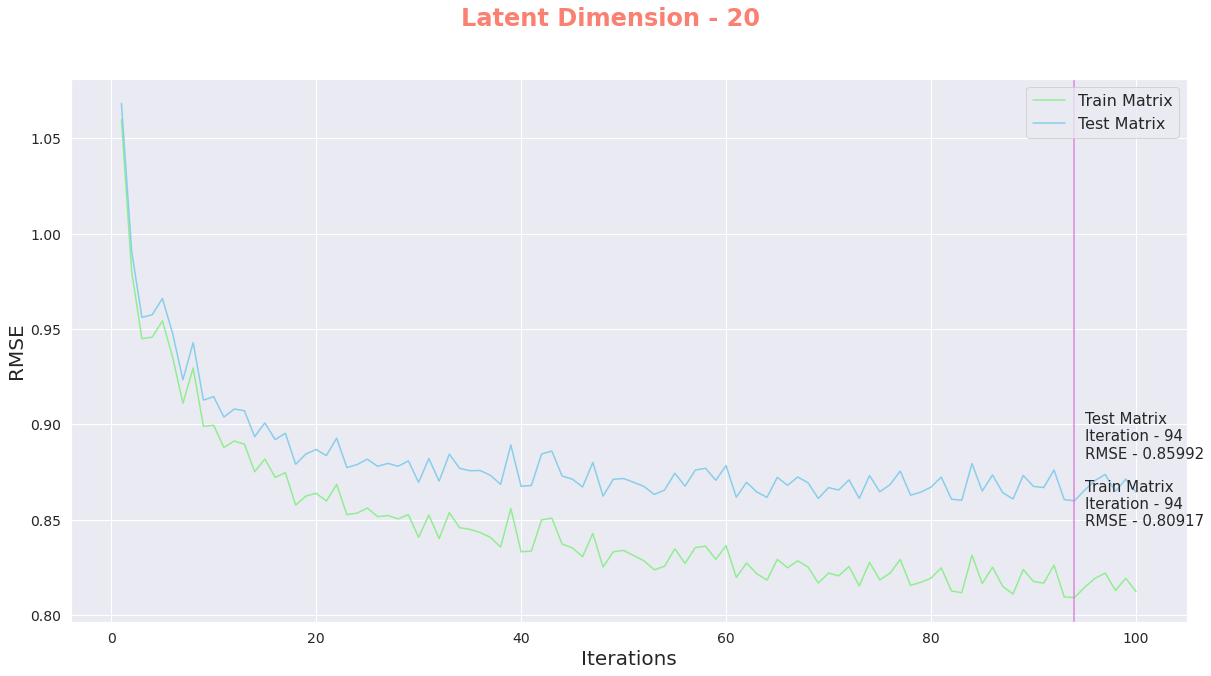

In [ ]:
plot_results(k_factor=20, what='RMSE', m1=train_rmse_k_20, m1_desc='Train Matrix', m2=test_rmse_k_20, m2_desc='Test Matrix')

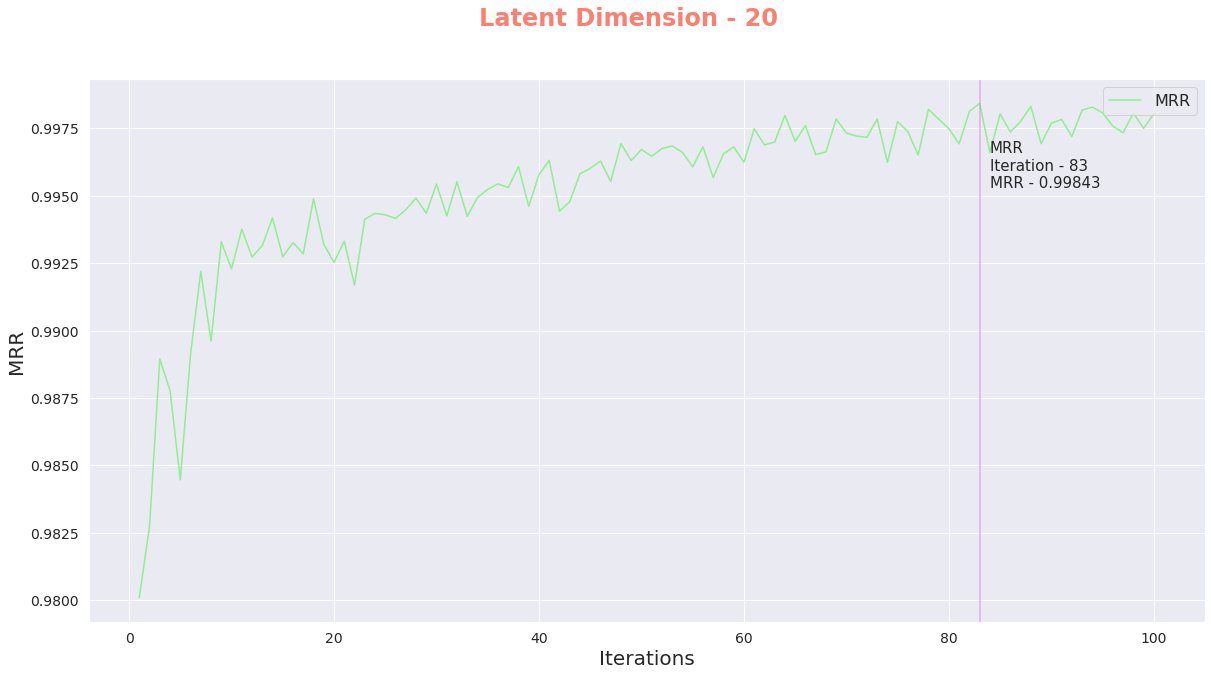

In [ ]:
plot_results(k_factor=20, what='MRR', m1=mrr_k_20, m1_desc='MRR', mark_max=True)

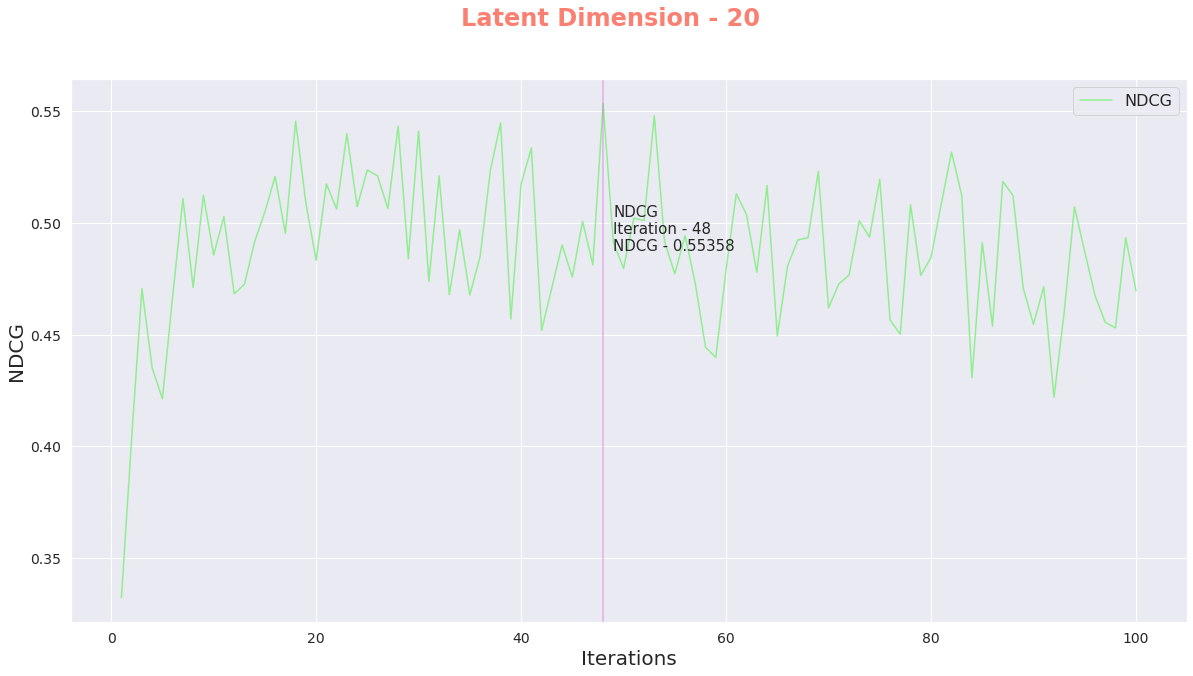

In [ ]:
plot_results(k_factor=20, what='NDCG', m1=ndcg_k_20, m1_desc='NDCG', mark_max=True)

#### Latent Dimension - 50

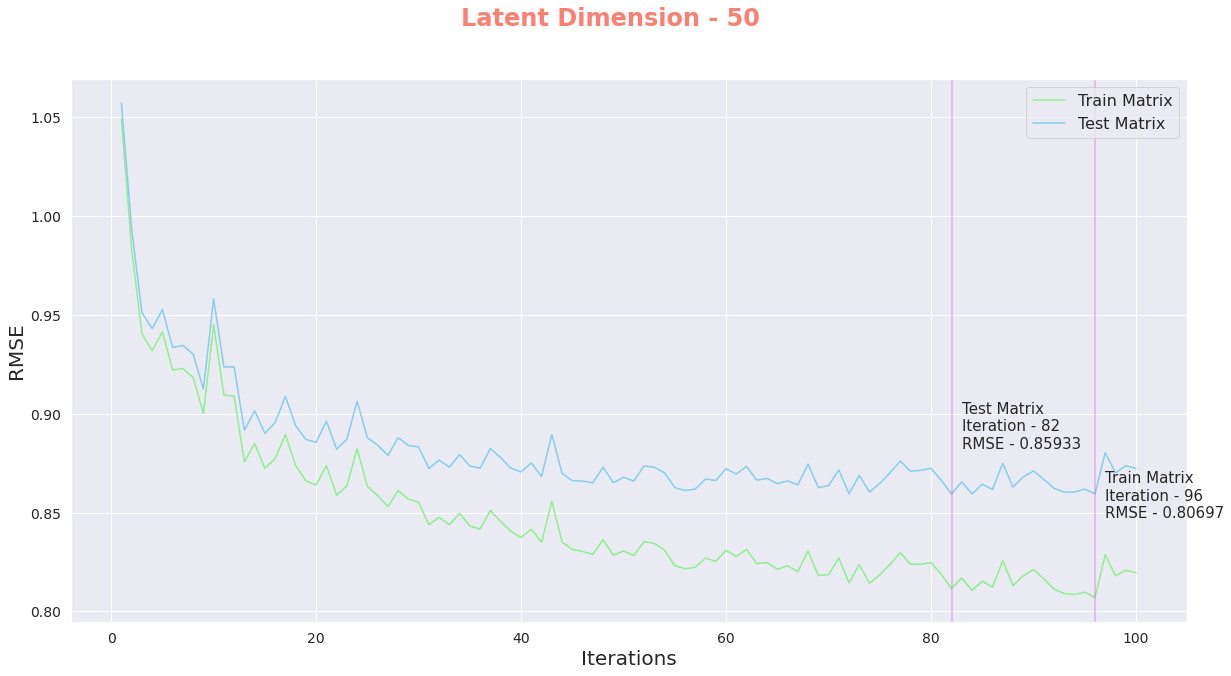

In [ ]:
plot_results(k_factor=50, what='RMSE', m1=train_rmse_k_50, m1_desc='Train Matrix', m2=test_rmse_k_50, m2_desc='Test Matrix')

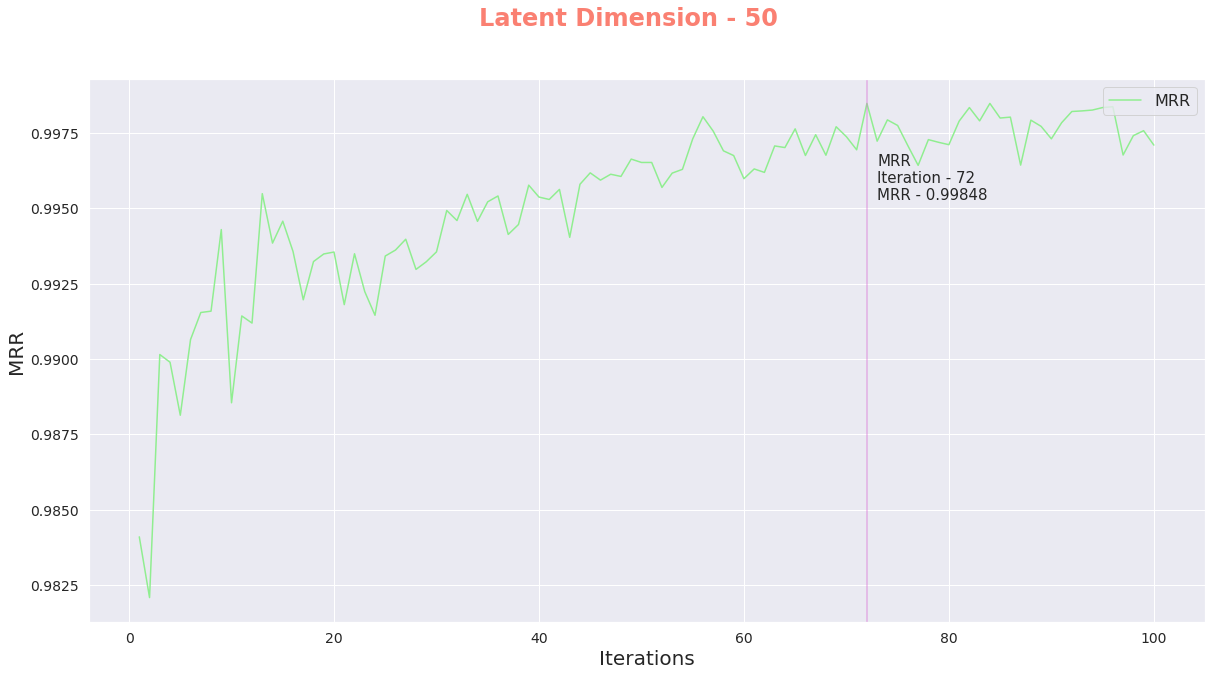

In [ ]:
plot_results(k_factor=50, what='MRR', m1=mrr_k_50, m1_desc='MRR', mark_max=True)

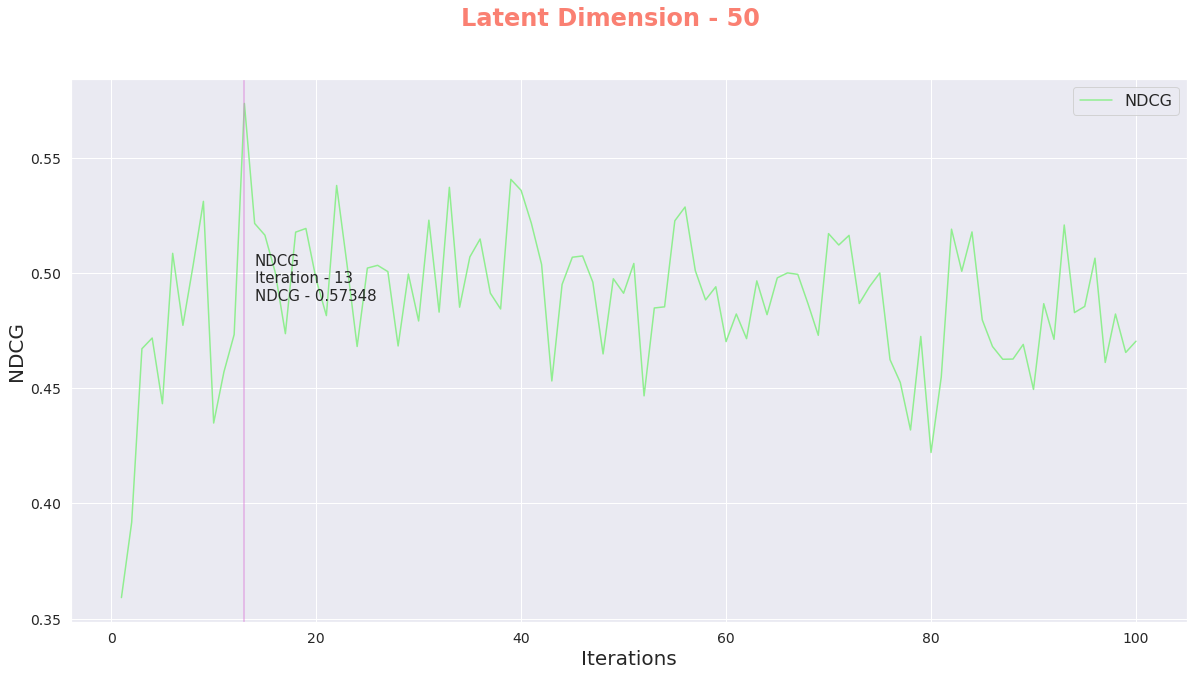

In [ ]:
plot_results(k_factor=50, what='NDCG', m1=ndcg_k_50, m1_desc='NDCG', mark_max=True)

#### Latent Dimension - 100

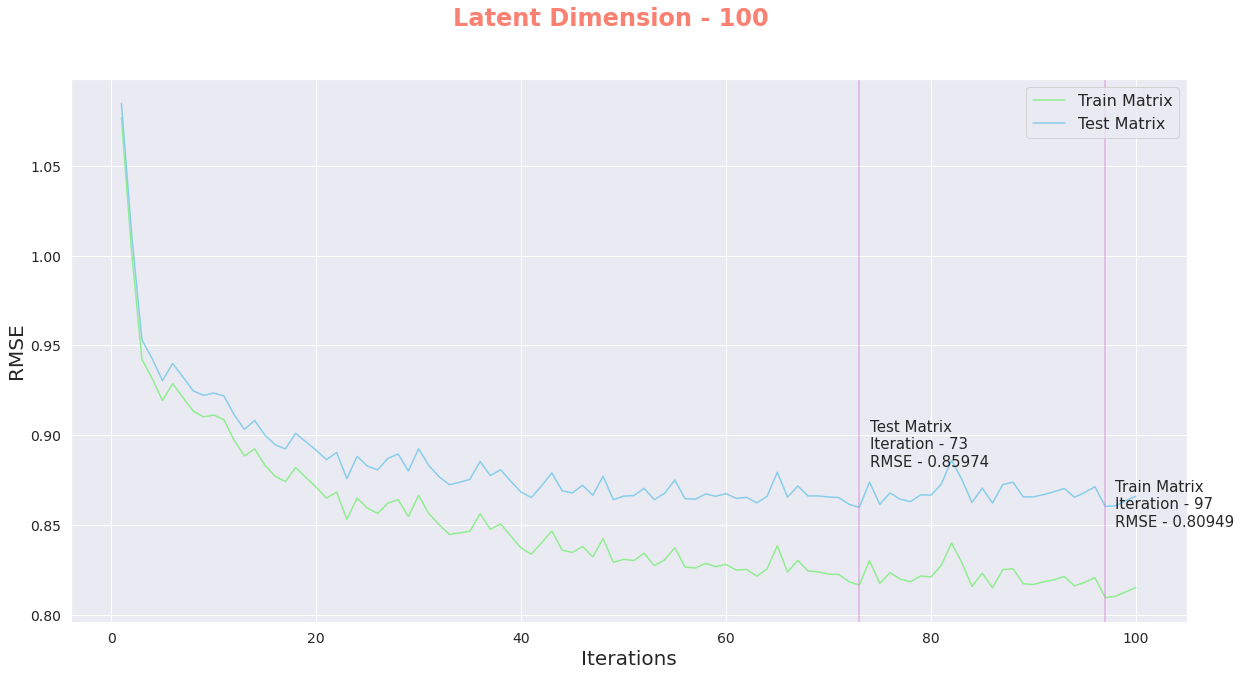

In [ ]:
plot_results(k_factor=100, what='RMSE', m1=train_rmse_k_100, m1_desc='Train Matrix', m2=test_rmse_k_100, m2_desc='Test Matrix')

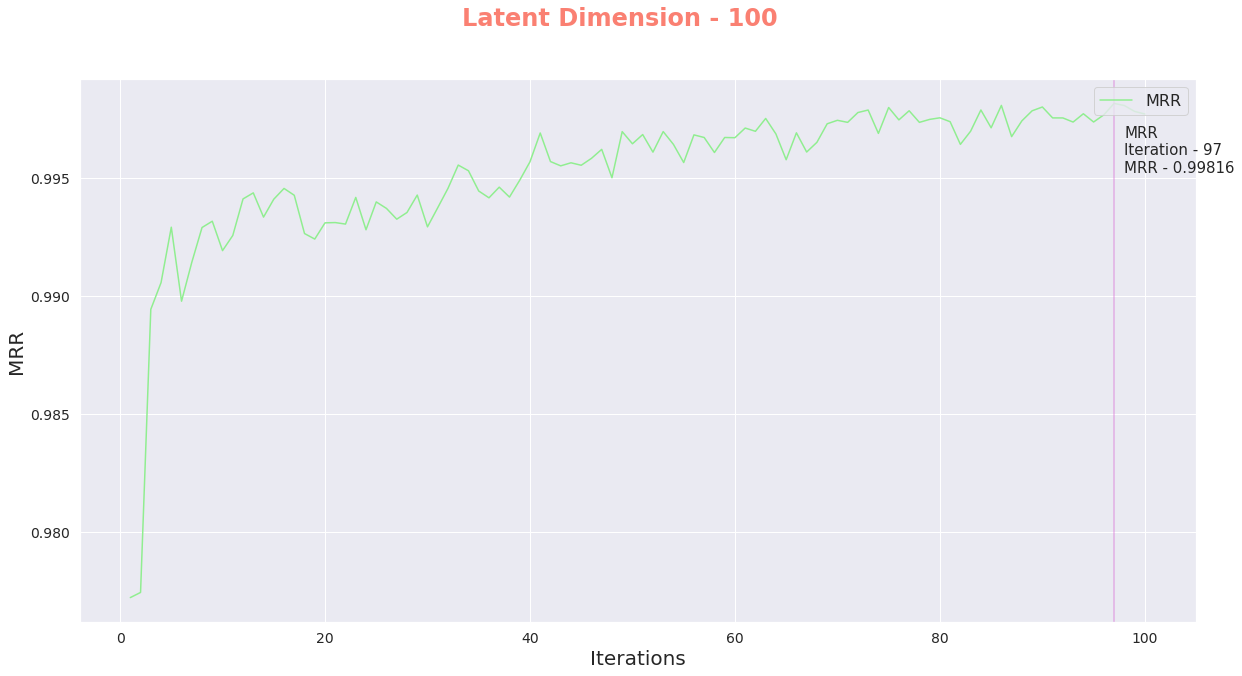

In [ ]:
plot_results(k_factor=100, what='MRR', m1=mrr_k_100, m1_desc='MRR', mark_max=True)

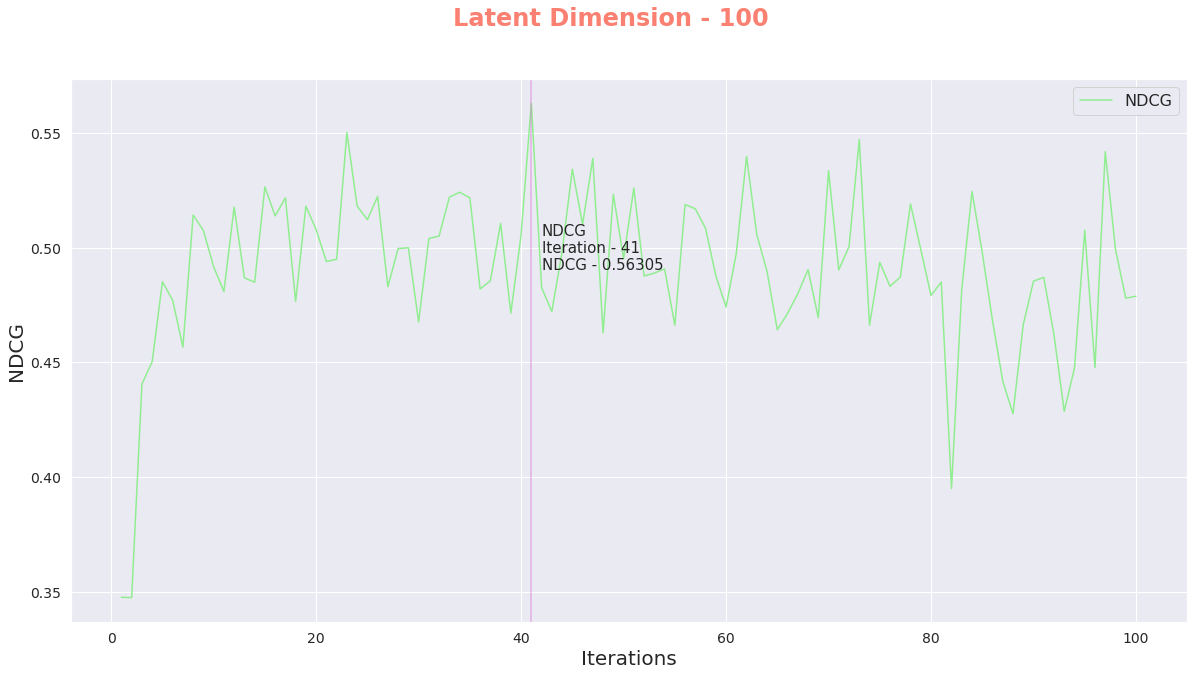

In [ ]:
plot_results(k_factor=100, what='NDCG', m1=ndcg_k_100, m1_desc='NDCG', mark_max=True)

# Method - Neural Collaborative Filtering

## Setup

In [ ]:
import numpy as np
import scipy
import scipy.sparse as sp

In [ ]:
from tensorflow import keras
import keras

In [ ]:
from time import time
import math
import os
from os.path import join as os_join
import heapq
import multiprocessing

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Global Variables

In [ ]:
_model = None
_testRatings = None
_testNegatives = None
_K = None

## Dataset Handling

In [ ]:
class Dataset(object):

    def __init__(self, _path: str, dataset_name: str):
        self.trainMatrix = self.load_rating_file_as_matrix(os_join(_path, f'{dataset_name}.train.rating'))
        self.testRatings = self.load_rating_file_as_list(os_join(_path, f'{dataset_name}.test.rating'))
        self.testNegatives = self.load_negative_file(os_join(_path, f'{dataset_name}.test.negative'))

        assert len(self.testRatings) == len(self.testNegatives)

        self.num_users, self.num_items = self.trainMatrix.shape

    def load_rating_file_as_list(self, filename: str) -> list:
        rating = []

        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and not "".__eq__(line):
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])

                rating.append([user, item])

                line = f.readline()

        return rating

    def load_negative_file(self, filename: str) -> list:
        negative = []

        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and not "".__eq__(line):
                arr = line.split("\t")

                negative.append([int(_) for _ in arr[1:]])

                line = f.readline()

        return negative

    def load_rating_file_as_matrix(self, filename: str) -> sp.dok_matrix:
        """
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        """

        if os.path.exists(f'{filename}.npz'):
            return scipy.sparse.load_npz(f'{filename}.npz').todok()

        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and not "".__eq__(line):
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix

        mat = sp.dok_matrix((num_users + 1, num_items + 1), dtype=np.float32)

        counter = 0
        with open(filename, "r") as f:
            line = f.readline()
            while line is not None and not "".__eq__(line):
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if rating > 0:
                    mat[user, item] = 1.0
                line = f.readline()

        scipy.sparse.save_npz(f'{filename}.npz', mat.tocoo())

        return mat

## Evaluation

In [ ]:
def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K

    mrrs, ndcgs = [], []
    if num_thread > 1:  # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        mrrs = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return mrrs, ndcgs
    # Single thread

    for idx in range(len(_testRatings)):
        (mrr, ndcg) = eval_one_rating(idx)
        mrrs.append(mrr)
        ndcgs.append(ndcg)
    return mrrs, ndcgs


def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype='int32')
    predictions = _model.predict([users, np.array(items)],
                                 batch_size=100, verbose=0)

    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()

    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    mrr = getMRR(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return mrr, ndcg


def getMRR(ranklist, gtItem):
    for i in range(0, len(ranklist)):
        if ranklist[i] == gtItem:
            return 1 / (i + 1)

    return 0


def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0

In [ ]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            try:
                while train.has_key((u, j)):
                    j = np.random.randint(num_items)
            except:
                sos = 0
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

## Models

### GMF

In [ ]:
def get_GMF_model(num_users: int, num_items: int, latent_dim: int, regs=None):
    # Generalized Matrix Factorization

    # Input variables
    if regs is None:
        regs = [[0, 0]]

    user_input = keras.layers.Input(shape=(1,), dtype='int32', name='user_input')
    item_input = keras.layers.Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = keras.layers.Embedding(
        input_dim=num_users, output_dim=latent_dim, name='user_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs[0][0]), input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    MF_Embedding_Item = keras.layers.Embedding(
        input_dim=num_items, output_dim=latent_dim, name='item_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs[0][1]), input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    # Crucial to flatten an embedding vector!
    user_latent = keras.layers.Flatten()(MF_Embedding_User(user_input))
    item_latent = keras.layers.Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings
    predict_vector = keras.layers.Multiply()(
        [user_latent, item_latent])  # merge([user_latent, item_latent], mode = 'mul')

    # Final prediction layer
    prediction = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name='prediction')(
        predict_vector)

    return keras.models.Model(inputs=[user_input, item_input], outputs=prediction)

### MLP

In [ ]:
def get_MLP_model(num_users: int, num_items: int, latent_dim: int, regs=None, layers=None):
    # Multi-Layer Perceptron

    if layers is None:
        layers = [20, 10]
    if regs is None:
        regs = [[0, 0], 0, 0]

    assert len(layers) + 1 == len(regs), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers)  # Number of layers in the MLP
    # Input variables
    user_input = keras.layers.Input(shape=(1,), dtype='int32', name='user_input')
    item_input = keras.layers.Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = keras.layers.Embedding(
        input_dim=num_users, output_dim=latent_dim, name='user_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs[0][0]), input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    MLP_Embedding_Item = keras.layers.Embedding(
        input_dim=num_items, output_dim=latent_dim, name='item_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs[0][1]), input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    # Crucial to flatten an embedding vector!
    user_latent = keras.layers.Flatten()(MLP_Embedding_User(user_input))
    item_latent = keras.layers.Flatten()(MLP_Embedding_Item(item_input))

    # Concatenation of embedding layers
    vector = keras.layers.Concatenate(axis=-1)(
        [user_latent, item_latent])  # merge([user_latent, item_latent], mode = 'concat')

    # MLP layers
    for idx in range(num_layer):
        layer = keras.layers.Dense(
            layers[idx],
            kernel_regularizer=keras.regularizers.l2(regs[idx + 1]),
            activation='relu',
            name='layer%d' % idx)

        vector = layer(vector)

    # Final prediction layer
    prediction = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name='prediction')(
        vector)

    return keras.models.Model(inputs=[user_input, item_input], outputs=prediction)

### NMF

In [ ]:
def get_NMF_model(num_users: int, num_items: int, latent_dim_GMF: int, latent_dim_MLP: int,
                  reg_GMF=None, regs_MLP=None, layers=None):
    # Neural matrix factorization
    if layers is None:
        layers = [20, 10]
    if reg_GMF is None:
        reg_GMF = [[0, 0]]
    if regs_MLP is None:
        regs_MLP = [[0, 0], 0, 0]

    assert len(layers) + 1 == len(regs_MLP), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers)  # Number of layers in the MLP

    # Input variables
    user_input = keras.layers.Input(shape=(1,), dtype='int32', name='user_input')
    item_input = keras.layers.Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    MF_Embedding_User = keras.layers.Embedding(
        input_dim=num_users, output_dim=latent_dim_GMF, name='MF_user_embedding',
        embeddings_regularizer=keras.regularizers.l2(reg_GMF[0][0]), input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    MF_Embedding_Item = keras.layers.Embedding(
        input_dim=num_items, output_dim=latent_dim_GMF, name='MF_item_embedding',
        embeddings_regularizer=keras.regularizers.l2(reg_GMF[0][1]),
        input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    MLP_Embedding_User = keras.layers.Embedding(
        input_dim=num_users, output_dim=latent_dim_MLP,
        name='MLP_user_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs_MLP[0][0]),
        input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    MLP_Embedding_Item = keras.layers.Embedding(
        input_dim=num_items, output_dim=latent_dim_MLP,
        name='MLP_item_embedding',
        embeddings_regularizer=keras.regularizers.l2(regs_MLP[0][1]),
        input_length=1,
        embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  # init = init_normal,

    # MF part
    mf_user_latent = keras.layers.Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = keras.layers.Flatten()(MF_Embedding_Item(item_input))
    mf_vector = keras.layers.Multiply()([mf_user_latent,
                                         mf_item_latent])  # merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply

    # MLP part
    mlp_user_latent = keras.layers.Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = keras.layers.Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = keras.layers.Concatenate(axis=-1)(
        [mlp_user_latent, mlp_item_latent])  # merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    for idx in range(num_layer):
        layer = keras.layers.Dense(layers[idx],
                                   kernel_regularizer=keras.regularizers.l2(regs_MLP[idx + 1]),
                                   activation='tanh',
                                   name='layer%d' % idx)

        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = keras.layers.Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = keras.layers.Dense(1,
                                    activation='sigmoid',
                                    kernel_initializer='lecun_uniform',
                                    name="prediction")(predict_vector)

    return keras.models.Model(inputs=[user_input, item_input], outputs=prediction)

## Main

In [ ]:
path = ''
dataset = 'ml-1m'
# dataset='pinterest-20'
t1 = time()
dataset = Dataset(_path=path, dataset_name=dataset)
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape
print("Users:", num_users)
print("Items:", num_items)

Users: 6040
Items: 3706


In [ ]:
num_factors = 8 #size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 #how many negative samples per positive sample?
learning_rate = 0.001
epochs = 10
batch_size = 256
verbose = 1
write_model=False
#topK = 10 #used to evaluate the model. Top K recommendations are used.
evaluation_threads = 1 
model_out_file = 'Pretrain/%s_GMF_%d_%d.h5' %(dataset, num_factors, time())

# Build model
#model = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
model = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8])
#model = get_NMF_model(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]],regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
______________________________________________________________________________________________

### GMF

In [ ]:
model = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
print("GMF")
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy')

GMF
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
________________________________________________________________________________________

### NMF

In [ ]:
model = get_NMF_model(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]],regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
print("NMF")
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy')

NMF
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP_user_embedding (Embedding)  (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
MLP_item_embedding (Embedding)  (None, 1, 8)         29648       item_input[0][0]                 
________________________________________________________________________________________

### MLP

In [ ]:
model = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8])
print("MLP")
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy')

MLP
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
________________________________________________________________________________________

In [ ]:
# Train model
mrr1_10, ndcg1_10, loss1_10 = [],[],[]
mrr1_5, ndcg1_5, loss1_5 = [],[],[]
for epoch in range(epochs):
    t1 = time()
    # Generate training instances
    user_input, item_input, labels = get_train_instances(train, num_negatives)

    # Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
    t2 = time()

    # Evaluation
    if epoch %verbose == 0:
        (mrrs, ndcgs) = evaluate_model(model, testRatings, testNegatives, 10, evaluation_threads)
        mrr, ndcg, loss = np.array(mrrs).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
        mrr1_10.append(mrr)
        ndcg1_10.append(ndcg)
        loss1_10.append(loss)

        (mrrs, ndcgs) = evaluate_model(model, testRatings, testNegatives, 5, evaluation_threads)
        mrr, ndcg, loss = np.array(mrrs).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
        mrr1_5.append(mrr)
        ndcg1_5.append(ndcg)
        loss1_5.append(loss)

        print('Iteration %d [%.1f s]: MRR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
              % (epoch,  t2-t1, mrr, ndcg, loss, time()-t2))

Iteration 0 [54.0 s]: MRR = 0.1697, NDCG = 0.2035, loss = 0.3894 [491.5 s]
Iteration 1 [51.7 s]: MRR = 0.1895, NDCG = 0.2271, loss = 0.3735 [483.4 s]
Iteration 2 [52.1 s]: MRR = 0.2008, NDCG = 0.2395, loss = 0.3584 [486.1 s]
Iteration 3 [51.9 s]: MRR = 0.2071, NDCG = 0.2475, loss = 0.3523 [490.4 s]
Iteration 4 [51.6 s]: MRR = 0.2148, NDCG = 0.2575, loss = 0.3452 [478.8 s]
Iteration 5 [52.5 s]: MRR = 0.2288, NDCG = 0.2718, loss = 0.3395 [478.2 s]
Iteration 6 [51.7 s]: MRR = 0.2310, NDCG = 0.2753, loss = 0.3357 [487.3 s]
Iteration 7 [51.7 s]: MRR = 0.2372, NDCG = 0.2829, loss = 0.3332 [486.0 s]
Iteration 8 [51.8 s]: MRR = 0.2413, NDCG = 0.2871, loss = 0.3312 [485.7 s]
Iteration 9 [52.4 s]: MRR = 0.2407, NDCG = 0.2873, loss = 0.3300 [492.0 s]


In [ ]:
print(mrr1_10)
print()
print(ndcg1_10)
print()
print(loss1_10)
print()
print(mrr1_5)
print()
print(ndcg1_5)
print()
print(loss1_5)

[0.1889825107747293, 0.21097839798170925, 0.22319437874487544, 0.23074549300956587, 0.23861656417533902, 0.2528493903079996, 0.2545374093345948, 0.2609878587196468, 0.2651720014716703, 0.2647421948912015]

[0.2506744320299113, 0.2792588142037547, 0.2937600378366789, 0.30450617718918677, 0.31558454919258766, 0.33049269040324675, 0.33218621470926174, 0.34058621439534476, 0.34513017837972304, 0.34562225162403437]

[0.38937240839004517, 0.37353286147117615, 0.35835033655166626, 0.35225042700767517, 0.34521493315696716, 0.33949360251426697, 0.3356839418411255, 0.3331637978553772, 0.331238716840744, 0.32999083399772644]

[0.16967163355408388, 0.18945916114790282, 0.20081953642384107, 0.20710816777041943, 0.21477097130242823, 0.2287858719646799, 0.2309878587196468, 0.23722406181015454, 0.24132726269315674, 0.2406512141280353]

[0.20350451356968047, 0.2271449155471578, 0.23946475202888848, 0.24747371029441206, 0.2574929229877441, 0.2718360971838755, 0.2752759132074068, 0.2828609277027514, 0.28

## Results

In [ ]:
def plot_results(model_name: str, mrr: list, ndcg: list, loss: list):
    fig, axs = plt.subplots(2, 3)
    fig: plt.Figure = fig
    fig.set_size_inches(24, 12)
    fig.suptitle(f'Model - {model_name}', fontsize=24, fontweight='bold', color='salmon')

    cols_color = ['orchid', 'skyblue', 'lightgreen']
    fsize = 18
    weight = 'bold'

    axs[0, 0]: plt.Axes = axs[0, 0]

    axs[0, 0].plot(mrr[0], color=cols_color[0])
    axs[0, 0].set_title("MRR 5", fontsize=fsize, fontweight=weight, color=cols_color[0])

    axs[0, 1].plot(ndcg[0], color=cols_color[1])
    axs[0, 1].set_title("NDCG 5", fontsize=fsize, fontweight=weight, color=cols_color[1])

    axs[0, 2].plot(loss[0], color=cols_color[2])
    axs[0, 2].set_title("Loss 5", fontsize=fsize, fontweight=weight, color=cols_color[2])

    axs[1, 0].plot(mrr[1], color=cols_color[0])
    axs[1, 0].set_title("MRR 10", fontsize=fsize, fontweight=weight, color=cols_color[0])

    axs[1, 1].plot(ndcg[1], color=cols_color[1])
    axs[1, 1].set_title("NDCG 10", fontsize=fsize, fontweight=weight, color=cols_color[1])

    axs[1, 2].plot(loss[1], color=cols_color[2])
    axs[1, 2].set_title("Loss 10", fontsize=fsize, fontweight=weight, color=cols_color[2])

    plt.show()

### GMF

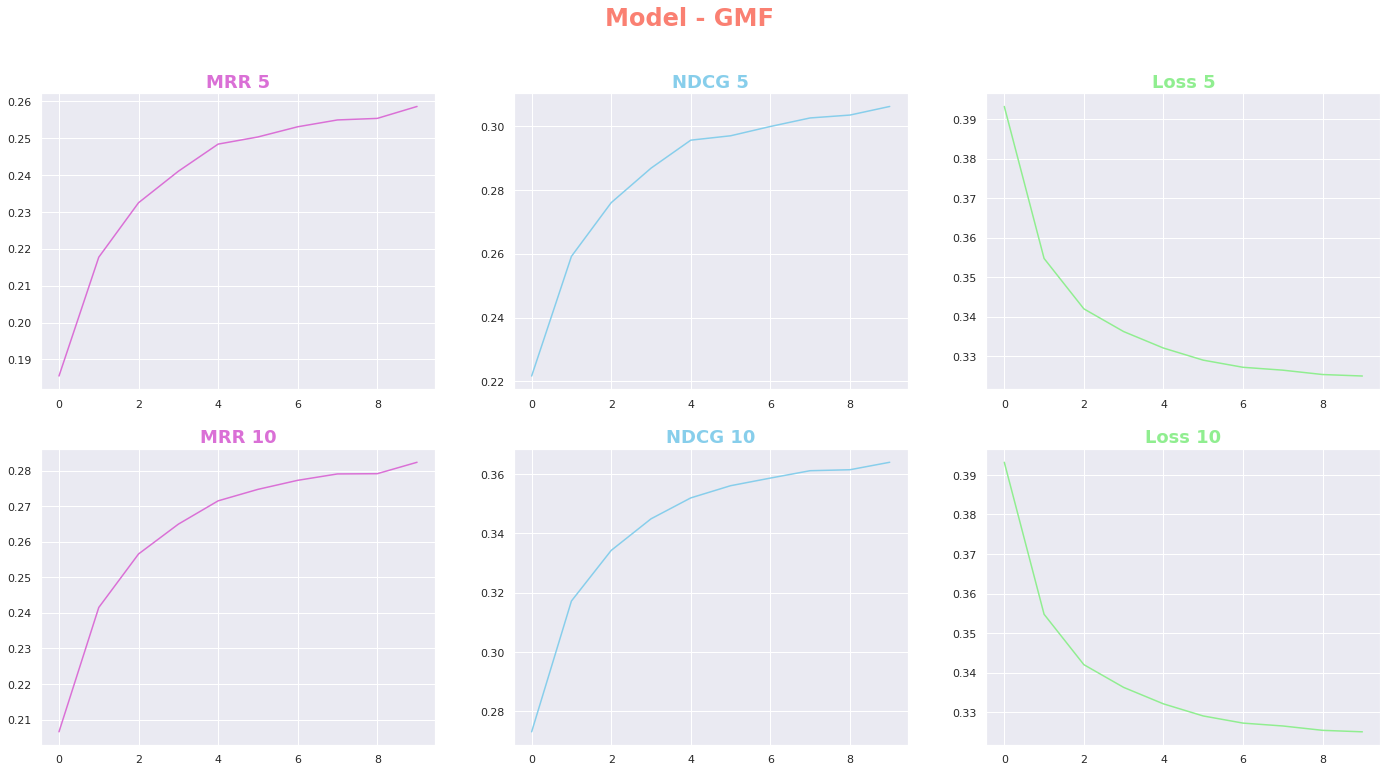

In [ ]:
gmf_mrr_5 = [0.18548841059602653, 0.21772626931567327, 0.23251103752759383, 0.24104856512141282, 0.248416114790287,
             0.2503559602649007, 0.2531208609271523, 0.2549751655629139, 0.25539459161147904, 0.2586341059602649]

gmf_mrr_10 = [0.20656181015452538, 0.2415145064648376, 0.2565642410385788, 0.2649400819930621, 0.27149781877430884,
              0.2747226164196363, 0.27726637233259754, 0.27906194155366343, 0.2791286923157784, 0.2823409413434248]

gmf_ndcg_5 = [0.22170642621192876, 0.2591820271892555, 0.27600434206563224, 0.2868044045745243, 0.2955786117640386,
              0.29694958885706774, 0.2998631305757476, 0.30253571622832254, 0.303437244176973, 0.30613578366470867]

gmf_ndcg_10 = [0.27314970210795897, 0.31721374041705647, 0.33427044399880185, 0.3449021904414302, 0.351956820884354,
               0.35605839773068965, 0.35862875228298563, 0.36111554534951, 0.3614419799889579, 0.3639568676501023]

gmf_loss_5 = [0.3932027816772461, 0.35474759340286255, 0.34199607372283936, 0.33624789118766785, 0.33208250999450684,
              0.32902032136917114, 0.3272136151790619, 0.32648685574531555, 0.325383722782135, 0.32500770688056946]
              
gmf_loss_10 = [0.3932027816772461, 0.35474759340286255, 0.34199607372283936, 0.33624789118766785, 0.33208250999450684,
               0.32902032136917114, 0.3272136151790619, 0.32648685574531555, 0.325383722782135, 0.32500770688056946]

plot_results(model_name='GMF', mrr=[gmf_mrr_5, gmf_mrr_10], ndcg=[gmf_ndcg_5, gmf_ndcg_10], loss=[gmf_loss_5, gmf_loss_10])

### NMF

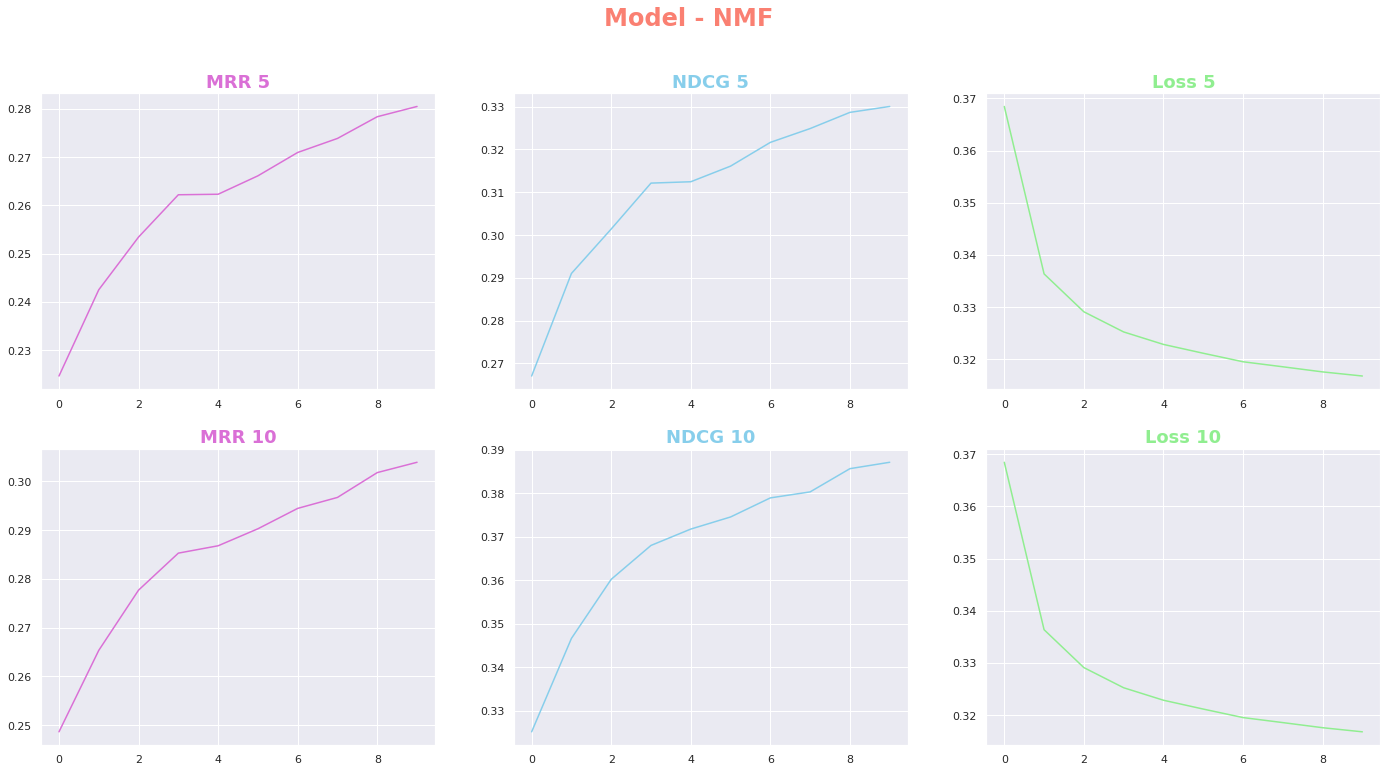

In [ ]:
nmf_mrr_5 = [0.22462472406181017, 0.24249724061810154, 0.253416114790287, 0.26218267108167775, 0.26229028697571743,
             0.26610651214128034, 0.27094646799116995, 0.27385485651214125, 0.2783554083885209, 0.2804801324503311]

nmf_mrr_10 = [0.24864396089561652, 0.2653405208661831, 0.2776886234626301, 0.2852724561126879, 0.28678150951329756,
              0.2902649663618207, 0.2944454299379796, 0.2966938005886681, 0.3017823636076947, 0.30389887522337855]

nmf_ndcg_5 = [0.26703634937865056, 0.2909946945914097, 0.3013836208715095, 0.3121065936772138, 0.312423684014678,
              0.31607328886508645, 0.3216201210285156, 0.3248498072887259, 0.32862997933298516, 0.3300136852946944]

nmf_ndcg_10 = [0.3251400218196694, 0.3466000130579469, 0.360180608450989, 0.3679646610477868, 0.3717235463420039,
               0.3745023741131554, 0.3788863027605228, 0.38026699839697237, 0.3856020837862245, 0.387071078736879]

nmf_loss_5 = [0.3684675693511963, 0.33634811639785767, 0.3290799856185913, 0.32521557807922363, 0.3228219747543335,
              0.32112783193588257, 0.31949499249458313, 0.31853237748146057, 0.3175507187843323, 0.31676149368286133]

nmf_loss_10 = [0.3684675693511963, 0.33634811639785767, 0.3290799856185913, 0.32521557807922363, 0.3228219747543335,
               0.32112783193588257, 0.31949499249458313, 0.31853237748146057, 0.3175507187843323, 0.31676149368286133]

plot_results(model_name='NMF', mrr=[nmf_mrr_5, nmf_mrr_10], ndcg=[nmf_ndcg_5, nmf_ndcg_10], loss=[nmf_loss_5, nmf_loss_10])

### MLP

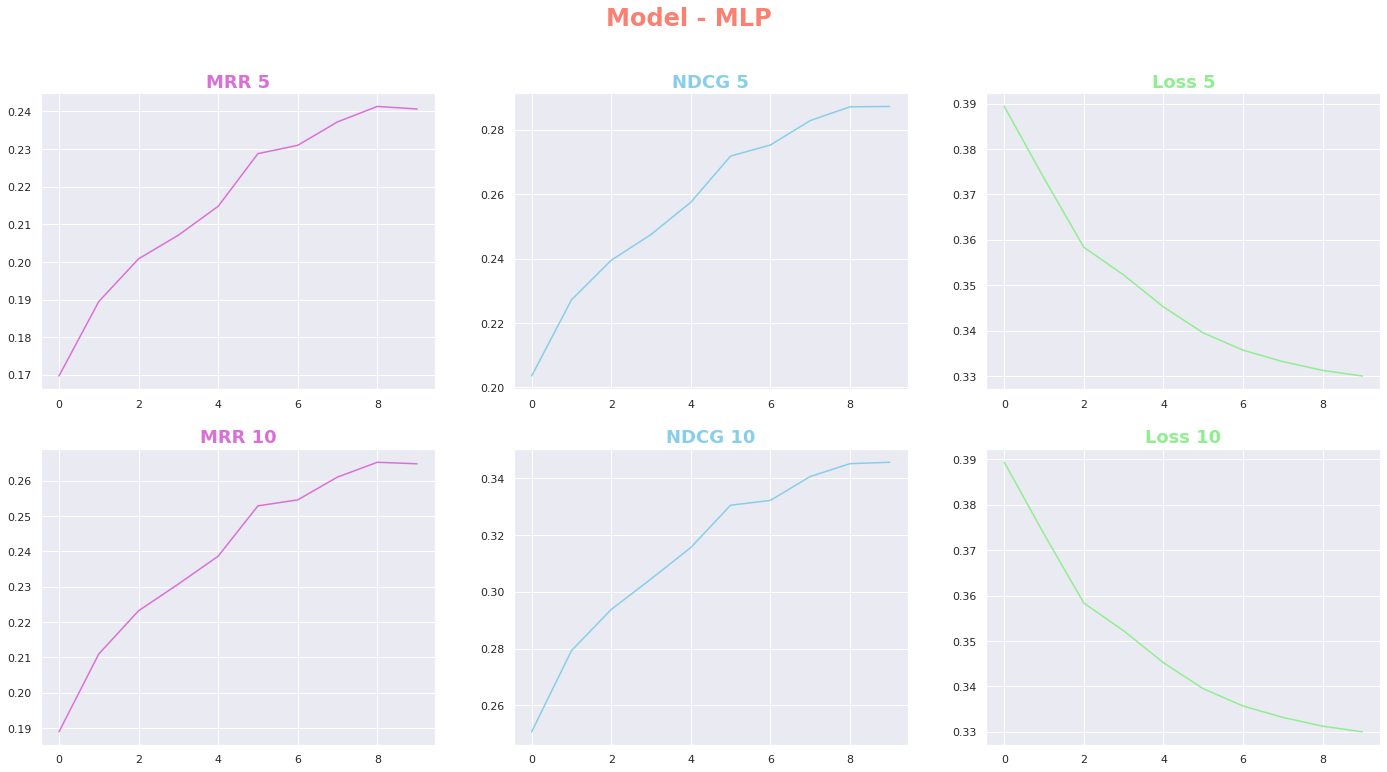

In [ ]:
mlp_mrr_5 = [0.16967163355408388, 0.18945916114790282, 0.20081953642384107, 0.20710816777041943, 0.21477097130242823,
             0.2287858719646799, 0.2309878587196468, 0.23722406181015454, 0.24132726269315674, 0.2406512141280353]

mlp_mrr_10 = [0.1889825107747293, 0.21097839798170925, 0.22319437874487544, 0.23074549300956587, 0.23861656417533902,
              0.2528493903079996, 0.2545374093345948, 0.2609878587196468, 0.2651720014716703, 0.2647421948912015]

mlp_ndcg_5 = [0.20350451356968047, 0.2271449155471578, 0.23946475202888848, 0.24747371029441206, 0.2574929229877441,
              0.2718360971838755, 0.2752759132074068, 0.2828609277027514, 0.28713760329210086, 0.2872577016972732]

mlp_ndcg_10 = [0.2506744320299113, 0.2792588142037547, 0.2937600378366789, 0.30450617718918677, 0.31558454919258766,
               0.33049269040324675, 0.33218621470926174, 0.34058621439534476, 0.34513017837972304, 0.34562225162403437]

mlp_loss_5 = [0.38937240839004517, 0.37353286147117615, 0.35835033655166626, 0.35225042700767517, 0.34521493315696716,
              0.33949360251426697, 0.3356839418411255, 0.3331637978553772, 0.331238716840744, 0.32999083399772644]

mlp_loss_10 = [0.38937240839004517, 0.37353286147117615, 0.35835033655166626, 0.35225042700767517, 0.34521493315696716,
               0.33949360251426697, 0.3356839418411255, 0.3331637978553772, 0.331238716840744, 0.32999083399772644]

plot_results(model_name='MLP', mrr=[mlp_mrr_5, mlp_mrr_10], ndcg=[mlp_ndcg_5, mlp_ndcg_10], loss=[mlp_loss_5, mlp_loss_10])

### MLP - RELU & MSE

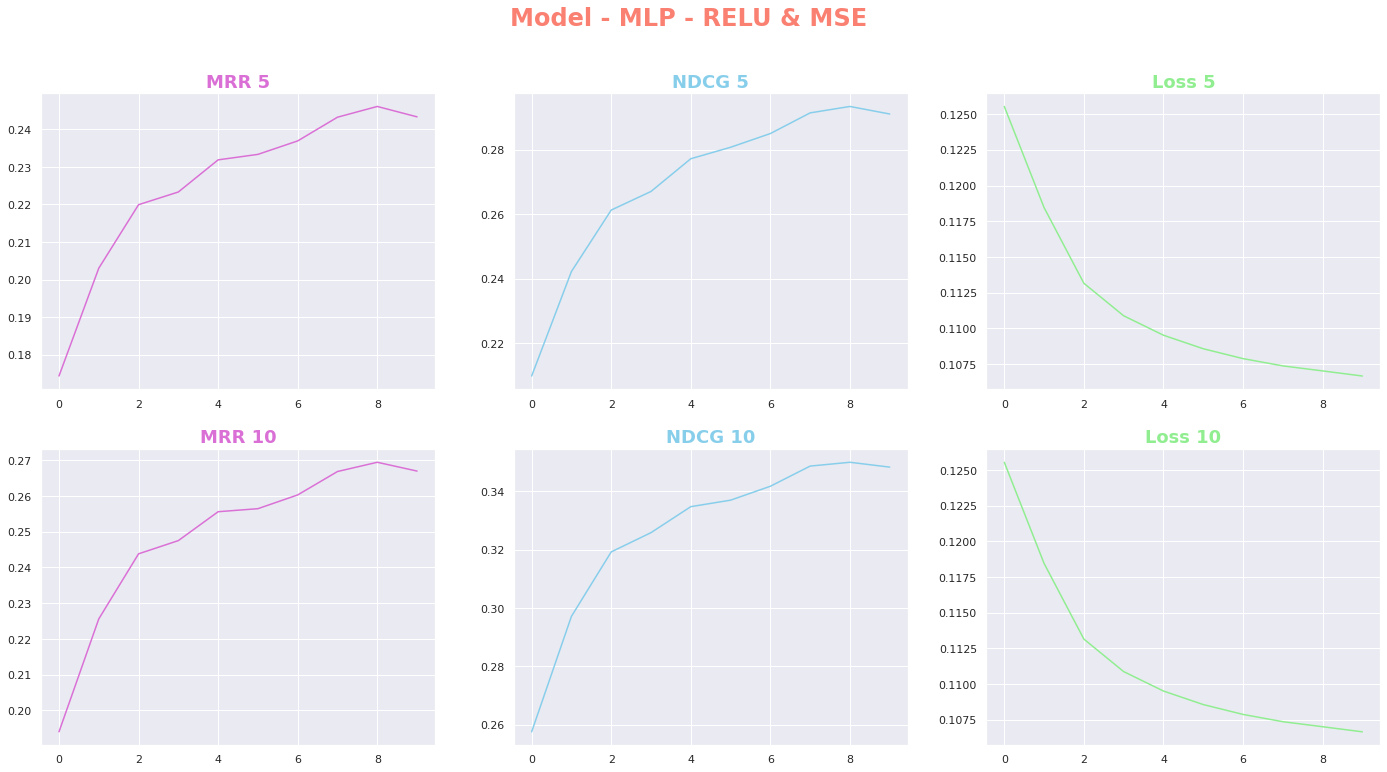

In [ ]:
mlp_relu_mse_mrr_5 = [0.17432395143487855, 0.20302152317880795, 0.21993653421633552, 0.22332229580573953,
                      0.23187637969094924,
                      0.23333609271523179, 0.2369205298013245, 0.24323399558498895, 0.2460954746136865,
                      0.24332781456953642]

mlp_relu_mse_mrr_10 = [0.19400300904026072, 0.22558604015557657, 0.2438065016293493, 0.2475047303689688,
                       0.2555895222327342,
                       0.2564390833596132, 0.26028776411226745, 0.2668368942499737, 0.26942631136339745,
                       0.2669613292336802]

mlp_relu_mse_ndcg_5 = [0.20975643435495925, 0.24219060978667403, 0.2612754297947975, 0.2670554012385824,
                       0.2772120493775414,
                       0.2807726909235527, 0.2850314550399722, 0.2914506612394258, 0.2934430186432693,
                       0.2910977467802533]

mlp_relu_mse_ndcg_10 = [0.25760527055555643, 0.29717068768566834, 0.31925947764121815, 0.32585882785199277,
                        0.3347628374007549,
                        0.3369873538848945, 0.3417566913604262, 0.3486662172013639, 0.34997517713798676,
                        0.3483102853774539]

mlp_relu_mse_loss_5 = [0.12553974986076355, 0.11845526099205017, 0.11315561085939407, 0.11087869852781296,
                       0.10951735824346542,
                       0.10856986790895462, 0.10787861794233322, 0.10736911743879318, 0.10701700299978256,
                       0.1066596731543541]

mlp_relu_mse_loss_10 = [0.12553974986076355, 0.11845526099205017, 0.11315561085939407, 0.11087869852781296,
                        0.10951735824346542,
                        0.10856986790895462, 0.10787861794233322, 0.10736911743879318, 0.10701700299978256,
                        0.1066596731543541]

plot_results(model_name='MLP - RELU & MSE',
             mrr=[mlp_relu_mse_mrr_5, mlp_relu_mse_mrr_10],
             ndcg=[mlp_relu_mse_ndcg_5, mlp_relu_mse_ndcg_10],
             loss=[mlp_relu_mse_loss_5, mlp_relu_mse_loss_10])

In [ ]:
def plot_comparison(model_name: str, mrr: list, ndcg: list, loss: list):
    fig, axs = plt.subplots(2, 3)
    fig: plt.Figure = fig
    fig.set_size_inches(24, 12)
    fig.suptitle(f'Models Comparison (MLP)', fontsize=20, fontweight='bold', color='salmon')

    cols_color = ['orchid', 'skyblue', 'lightgreen']

    axs[0, 0]: plt.Axes = axs[0, 0]

    axs[0, 0].plot(mrr[0][0], color=cols_color[0], label='Q2')
    axs[0, 0].plot(mrr[1][0], color=cols_color[0], linestyle='--', label='Q3')
    axs[0, 0].legend(loc='upper left', fontsize=12)
    axs[0, 0].set_title("MRR 5", fontsize=16, fontweight='bold', color=cols_color[0])

    axs[0, 1].plot(ndcg[0][0], color=cols_color[1], label='Q2')
    axs[0, 1].plot(ndcg[1][0], color=cols_color[1], linestyle='--', label='Q3')
    axs[0, 1].legend(loc='upper left', fontsize=12)
    axs[0, 1].set_title("NDCG 5", fontsize=16, fontweight='bold', color=cols_color[1])

    axs[0, 2].plot(loss[0][0], color=cols_color[2], label='Q2')
    axs[0, 2].plot(loss[1][0], color=cols_color[2], linestyle='--', label='Q3')
    axs[0, 2].legend(loc='upper right', fontsize=12)
    axs[0, 2].set_title("Loss 5", fontsize=16, fontweight='bold', color=cols_color[2])
    axs[0, 2].set_ylim(0.1, 0.4)

    axs[1, 0].plot(mrr[0][1], color=cols_color[0], label='Q2')
    axs[1, 0].plot(mrr[1][1], color=cols_color[0], linestyle='--', label='Q3')
    axs[1, 0].legend(loc='upper left', fontsize=12)
    axs[1, 0].set_title("MRR 10", fontsize=16, fontweight='bold', color=cols_color[0])

    axs[1, 1].plot(ndcg[0][1], color=cols_color[1], label='Q2')
    axs[1, 1].plot(ndcg[1][1], color=cols_color[1], linestyle='--', label='Q3')
    axs[1, 1].legend(loc='upper left', fontsize=12)
    axs[1, 1].set_title("NDCG 10", fontsize=16, fontweight='bold', color=cols_color[1])

    axs[1, 2].plot(loss[0][1], color=cols_color[2], label='Q2')
    axs[1, 2].plot(loss[1][1], color=cols_color[2], linestyle='--', label='Q3')
    axs[1, 2].legend(loc='upper right', fontsize=12)
    axs[1, 2].set_title("Loss 10", fontsize=16, fontweight='bold', color=cols_color[2])
    axs[1, 2].set_ylim(0.1, 0.4)

    plt.show()

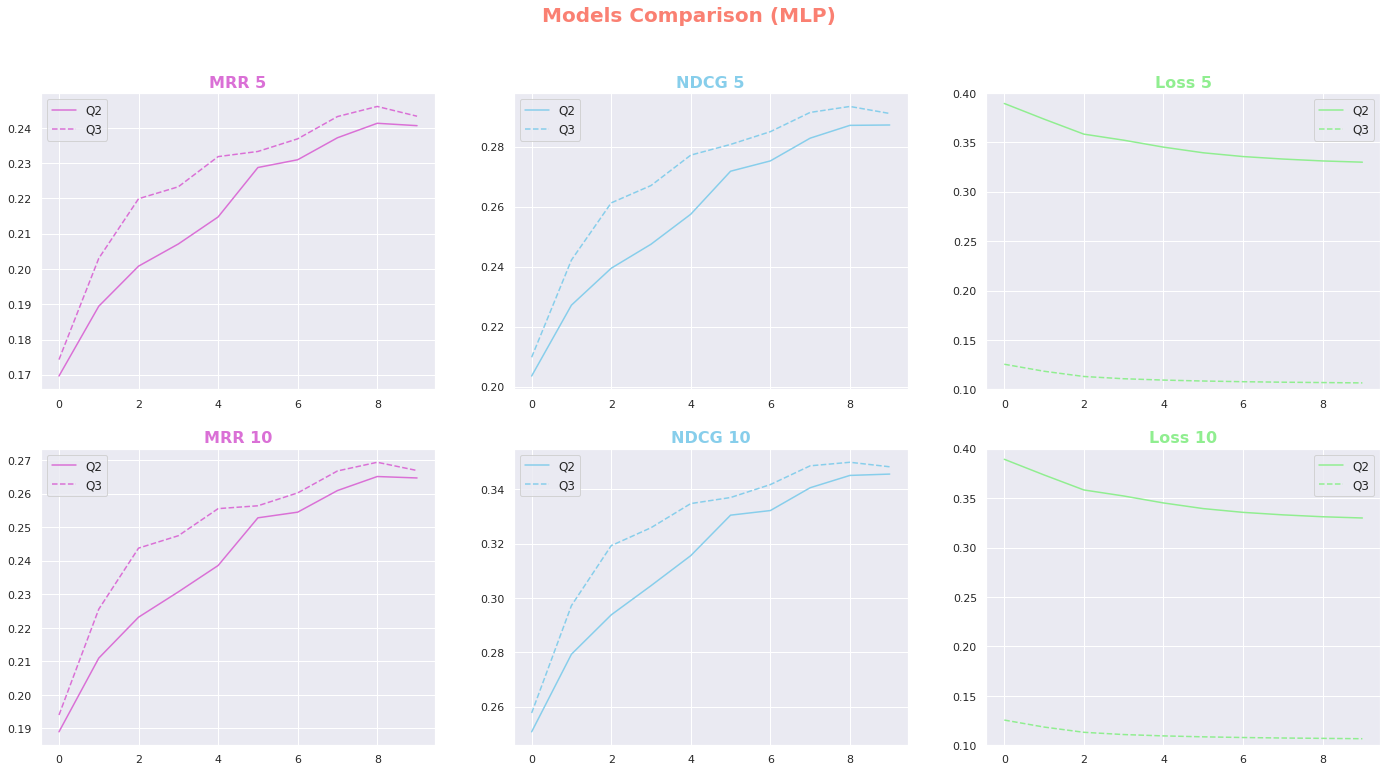

In [ ]:
plot_comparison(model_name='MLP Comparison',
                mrr=[[mlp_mrr_5, mlp_mrr_10], [mlp_relu_mse_mrr_5, mlp_relu_mse_mrr_10]],
                ndcg=[[mlp_ndcg_5, mlp_ndcg_10], [mlp_relu_mse_ndcg_5, mlp_relu_mse_ndcg_10]],
                loss=[[mlp_loss_5, mlp_loss_10], [mlp_relu_mse_loss_5, mlp_relu_mse_loss_10]])

## All Models Comparison

In [ ]:
def plot_comparison_all(mrr: list, ndcg: list, loss: list):
    fig, axs = plt.subplots(2, 3)
    fig: plt.Figure = fig
    fig.set_size_inches(24, 12)
    fig.suptitle(f'All Models Comparison', fontsize=20, fontweight='bold', color='salmon')

    cols_color = ['orchid', 'skyblue', 'lightgreen']

    axs[0, 0]: plt.Axes = axs[0, 0]

    axs[0, 0].plot(mrr[0][0], color=cols_color[0], label='MLP')
    axs[0, 0].plot(mrr[0][1], color=cols_color[0], linestyle='--', label='GMF')
    axs[0, 0].plot(mrr[0][2], color=cols_color[0], linestyle='-.', label='NMF')
    axs[0, 0].legend(loc='upper left', fontsize=12)
    axs[0, 0].set_title("MRR 5", fontsize=16, fontweight='bold', color=cols_color[0])

    axs[0, 1].plot(ndcg[0][0], color=cols_color[1], label='MLP')
    axs[0, 1].plot(ndcg[0][1], color=cols_color[1], linestyle='--', label='GMF')
    axs[0, 1].plot(ndcg[0][2], color=cols_color[1], linestyle='-.', label='NMF')
    axs[0, 1].legend(loc='upper left', fontsize=12)
    axs[0, 1].set_title("NDCG 5", fontsize=16, fontweight='bold', color=cols_color[1])

    axs[0, 2].plot(loss[0][0], color=cols_color[2], label='MLP')
    axs[0, 2].plot(loss[0][1], color=cols_color[2], linestyle='--', label='GMF')
    axs[0, 2].plot(loss[0][2], color=cols_color[2], linestyle='-.', label='NMF')
    axs[0, 2].legend(loc='upper right', fontsize=12)
    axs[0, 2].set_title("Loss 5", fontsize=16, fontweight='bold', color=cols_color[2])
    axs[0, 2].set_ylim(0.3, 0.4)

    axs[1, 0].plot(mrr[1][0], color=cols_color[0], label='MLP')
    axs[1, 0].plot(mrr[1][1], color=cols_color[0], linestyle='--', label='GMF')
    axs[1, 0].plot(mrr[1][2], color=cols_color[0], linestyle='-.', label='NMF')
    axs[1, 0].legend(loc='upper left', fontsize=12)
    axs[1, 0].set_title("MRR 10", fontsize=16, fontweight='bold', color=cols_color[0])

    axs[1, 1].plot(ndcg[1][0], color=cols_color[1], label='MLP')
    axs[1, 1].plot(ndcg[1][1], color=cols_color[1], linestyle='--', label='GMF')
    axs[1, 1].plot(ndcg[1][2], color=cols_color[1], linestyle='-.', label='NMF')
    axs[1, 1].legend(loc='upper left', fontsize=12)
    axs[1, 1].set_title("NDCG 10", fontsize=16, fontweight='bold', color=cols_color[1])

    axs[1, 2].plot(loss[1][0], color=cols_color[2], label='MLP')
    axs[1, 2].plot(loss[1][1], color=cols_color[2], linestyle='--', label='GMF')
    axs[1, 2].plot(loss[1][2], color=cols_color[2], linestyle='-.', label='NMF')
    axs[1, 2].legend(loc='upper right', fontsize=12)
    axs[1, 2].set_title("Loss 10", fontsize=16, fontweight='bold', color=cols_color[2])
    axs[1, 2].set_ylim(0.3, 0.4)

    plt.show()

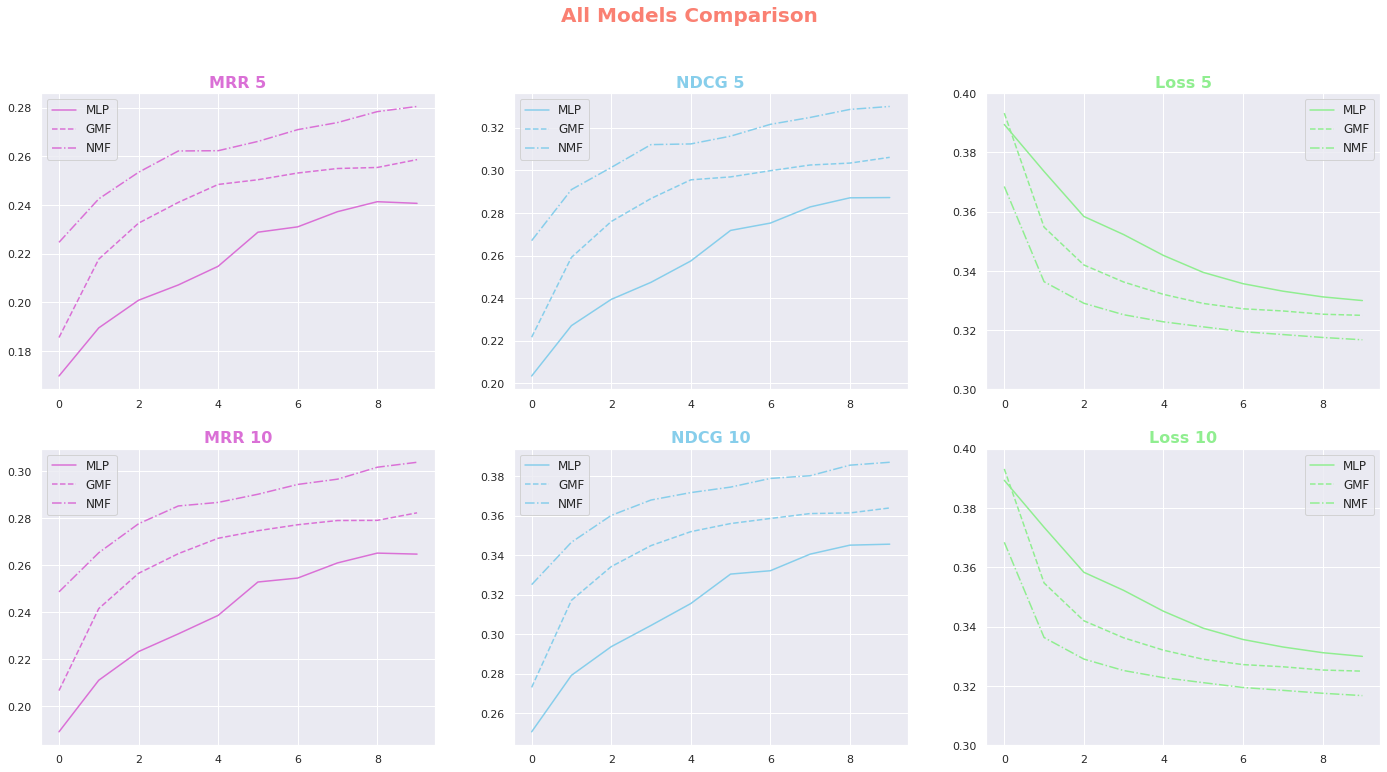

In [ ]:
plot_comparison_all(
    mrr=[[mlp_mrr_5, gmf_mrr_5, nmf_mrr_5], [mlp_mrr_10, gmf_mrr_10, nmf_mrr_10]],
    ndcg=[[mlp_ndcg_5, gmf_ndcg_5, nmf_ndcg_5], [mlp_ndcg_10, gmf_ndcg_10, nmf_ndcg_10]],
    loss=[[mlp_loss_5, gmf_loss_5, nmf_loss_5], [mlp_loss_10, gmf_loss_10, nmf_loss_10]]
)

The graph above reflects best the scores of our experiment, although MLP scores are lower than GMF where GMF with identity activation function and edge weights as 1 is MF, we do believe that with further learning (epochs) the MLP will outperform the GMF because MLP provides flexibility and non-linearity.

We can also see that NeuMF performs best - which is make sense because of his mix of the two approaches (as we can see in the picture down below).
Furthermore, looking at the learning process of each approach, MLP (and by so - NeuMF) learning curve is more smoothed than GMF which implies that the learning process is slow (make sense since we have more weights than GMF).

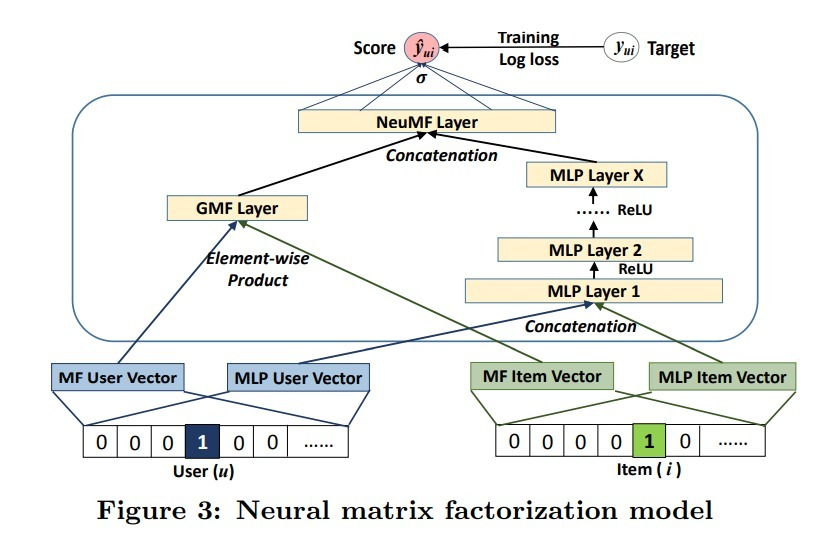

# Method - Generalized Matrix Factorisation (GMF) Weighted